# Unsupervised Domain Adaptation

#### Installing the required libraries

In [1]:
!pip install torchinfo

#### Loading in the required libraries

In [2]:
import torch
import torch.nn as nn
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.models import resnet50
from torchvision.models import ResNet50_Weights
from torchvision.datasets import MNIST, USPS, SVHN
from torchinfo import summary
from tqdm import tqdm
import torch.optim as optim
from sklearn.manifold import TSNE
import numpy as np
import random
from torch.autograd import Function
import time

#### Mounting the drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Setting the drive path to the folder

In [4]:
path = '/content/drive/MyDrive/ATML_PA5'
# Setting the path to this folder
os.chdir(path)
# Checking the current working directory
print(os.getcwd())

/content/drive/MyDrive/ATML_PA5


#### Setting the device

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("The device is: ", device)

The device is:  cuda


## Loading in the dataset

#### OFFICE-31 dataset

In [6]:
data_path = 'OFFICE31'
amazon_path = os.path.join(data_path, 'amazon')
webcam_path = os.path.join(data_path, 'webcam')
dslr_path = os.path.join(data_path, 'dslr')

print('amazon_path:', amazon_path)
print('webcam_path:', webcam_path)
print('dslr_path:', dslr_path)

def load_data(root_path, domain, batch_size, phase):
    transform_dict = {
        'src': transforms.Compose(
        [transforms.RandomResizedCrop(224),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
         ]),
        'tar': transforms.Compose(
        [transforms.Resize(224),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
         ])}
    data = datasets.ImageFolder(root=os.path.join(root_path, domain), transform=transform_dict[phase])
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=phase=='src', drop_last=phase=='tar', num_workers=4)
    return data_loader

amazon_loader = load_data(data_path, 'amazon', 64, 'src')
webcam_loader = load_data(data_path, 'webcam', 64, 'tar')
dslr_loader = load_data(data_path, 'dslr', 64, 'tar')

# Checking the size of these data loaders
print('amazon_loader size:', len(amazon_loader))
print('webcam_loader size:', len(webcam_loader))
print('dslr_loader size:', len(dslr_loader))

# # Defining the transformations to be applied to the images
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(
#         mean=[0.485, 0.456, 0.406],
#         std=[0.229, 0.224, 0.225]
#     )
#     # transforms.Normalize((0.5,), (0.5,))          # Normalize to [-1, 1]
# ])

# # Loading in the datasets for each of the domains
# amazon_dataset = datasets.ImageFolder(amazon_path, transform=transform)
# webcam_dataset = datasets.ImageFolder(webcam_path, transform=transform)
# dslr_dataset = datasets.ImageFolder(dslr_path, transform=transform)

# # Defining the dataloaders
# batch_size = 64
# amazon_dataloader = DataLoader(amazon_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
# webcam_dataloader = DataLoader(webcam_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
# dslr_dataloader = DataLoader(dslr_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

# # Checking the size of the datasets
# print('Amazon dataset size:', len(amazon_dataset))
# print('Webcam dataset size:', len(webcam_dataset))
# print('DSLR dataset size:', len(dslr_dataset))

amazon_path: OFFICE31/amazon
webcam_path: OFFICE31/webcam
dslr_path: OFFICE31/dslr


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


amazon_loader size: 45
webcam_loader size: 12
dslr_loader size: 7


#### Digits datasets

In [28]:
# Define transformations for the datasets
transform_mnist_usps = transforms.Compose([
    transforms.Resize((224, 224)),                  # Resize to 224x224
    transforms.Grayscale(num_output_channels=3),  # Ensure grayscale images (for USPS/MNIST) and convert to 3 channels
    transforms.ToTensor(),                        # Convert to Tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    # transforms.Normalize((0.5,), (0.5,))          # Normalize to [-1, 1]
])

transform_svhn = transforms.Compose([
    transforms.Resize((224, 224)),                  # Resize to 224x224
    transforms.ToTensor(),                        # Convert to Tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    # transforms.Normalize((0.5,), (0.5,))          # Normalize to [-1, 1]
])

batch_size = 64

# Loading in MNIST dataset
mnist_train = MNIST(root='./data', train=True, download=True, transform=transform_mnist_usps)
mnist_test = MNIST(root='./data', train=False, download=True, transform=transform_mnist_usps)

# MNIST dataloaders
mnist_train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Loading in the USPS dataset
usps_train = USPS(root='./data', train=True, download=True, transform=transform_mnist_usps)
usps_test = USPS(root='./data', train=False, download=True, transform=transform_mnist_usps)

# USPS dataloaders
usps_train_loader = DataLoader(usps_train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
usps_test_loader = DataLoader(usps_test, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Loading in the SVHN dataset
svhn_train = SVHN(root='./data', split='train', download=True, transform=transform_svhn)
svhn_test = SVHN(root='./data', split='test', download=True, transform=transform_svhn)

# SVHN dataloaders
svhn_train_loader = DataLoader(svhn_train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
svhn_test_loader = DataLoader(svhn_test, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Print dataset sizes for verification
print(f"MNIST Train Size: {len(mnist_train)}")
print(f"MNIST Test Size: {len(mnist_test)}")
print(f"USPS Train Size: {len(usps_train)}")
print(f"USPS Test Size: {len(usps_test)}")
print(f"SVHN Train Size: {len(svhn_train)}")
print(f"SVHN Test Size: {len(svhn_test)}")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
MNIST Train Size: 60000
MNIST Test Size: 10000
USPS Train Size: 7291
USPS Test Size: 2007
SVHN Train Size: 73257
SVHN Test Size: 26032


#### Visualizing images from each domain

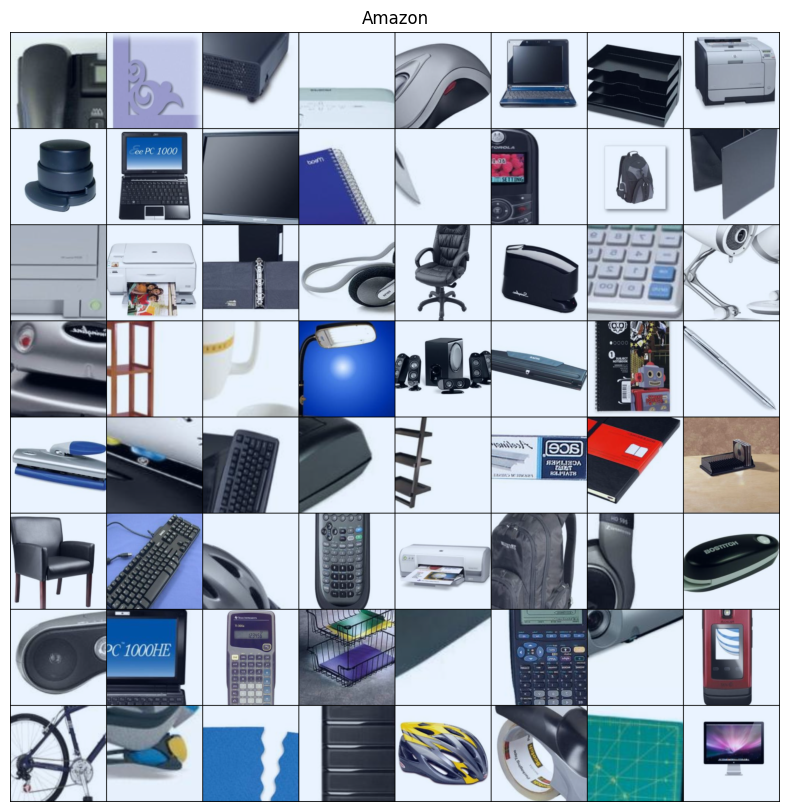

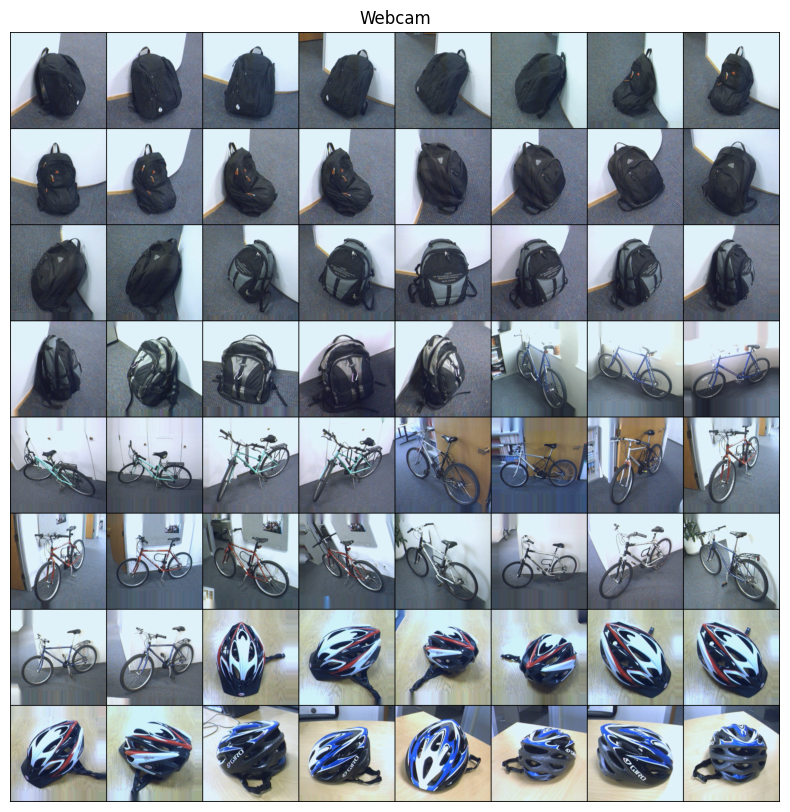

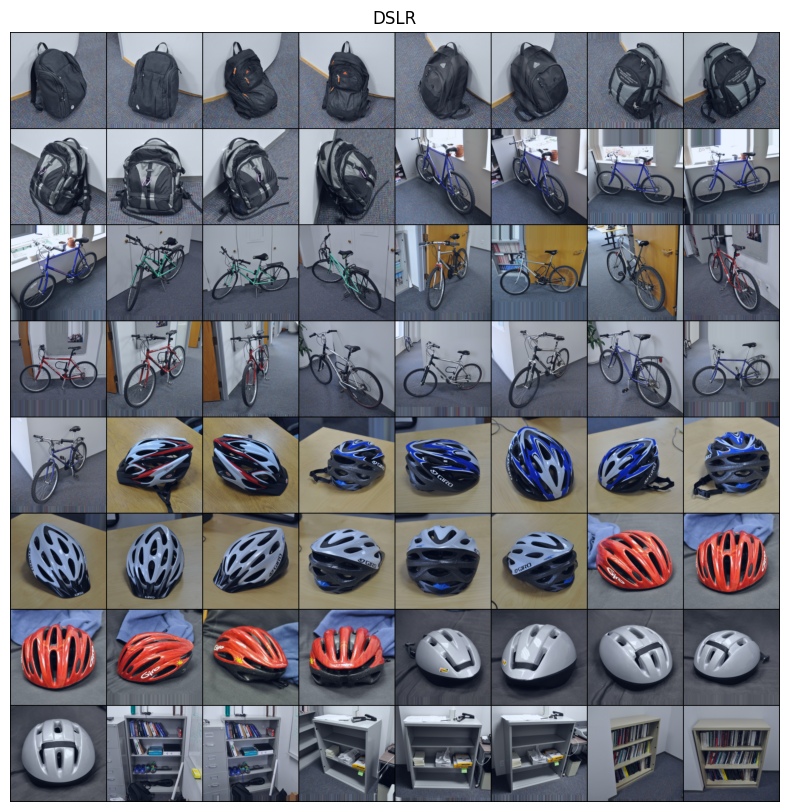

In [ ]:
# Displaying one image from each dataloders
def display_images(data_loader, title):
    data_iter = iter(data_loader)
    images, _ = next(data_iter)
    img_grid = make_grid(images[:64], nrow=8, normalize=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(img_grid, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Displaying the images
display_images(amazon_loader, 'Amazon')
display_images(webcam_loader, 'Webcam')
display_images(dslr_loader, 'DSLR')

#### Creating a small subsets of the dataloaders for experiments before scaling

In [29]:
# Function to create a subset
def create_subset(dataset, subset_size, seed=42):
    """
    Creates a random subset of the dataset.

    Args:
        dataset (Dataset): The original dataset.
        subset_size (int): The number of samples in the subset.
        seed (int): Random seed for reproducibility.

    Returns:
        Subset: A PyTorch Subset object.
    """
    random.seed(seed)
    indices = random.sample(range(len(dataset)), subset_size)
    return Subset(dataset, indices)

# Create subsets of the train and test datasets
mnist_train_subset = create_subset(mnist_train, 10000)
mnist_test_subset = create_subset(mnist_test, 5000)
usps_train_subset = create_subset(usps_train, 5000)
usps_test_subset = create_subset(usps_test, 1000)
svhn_train_subset = create_subset(svhn_train, 10000)
svhn_test_subset = create_subset(svhn_test, 5000)

# Creating the subset dataloaders
mnist_train_subset_loader = DataLoader(mnist_train_subset, batch_size=batch_size, shuffle=True)
mnist_test_subset_loader = DataLoader(mnist_test_subset, batch_size=batch_size, shuffle=False)
usps_train_subset_loader = DataLoader(usps_train_subset, batch_size=batch_size, shuffle=True)
usps_test_subset_loader = DataLoader(usps_test_subset, batch_size=batch_size, shuffle=False)
svhn_train_subset_loader = DataLoader(svhn_train_subset, batch_size=batch_size, shuffle=True)
svhn_test_subset_loader = DataLoader(svhn_test_subset, batch_size=batch_size, shuffle=False)


# Check the size of the subsets
print(f"MNIST Train Subset Size: {len(mnist_train_subset)}")
print(f"MNIST Test Subset Size: {len(mnist_test_subset)}")
print(f"USPS Train Subset Size: {len(usps_train_subset)}")
print(f"USPS Test Subset Size: {len(usps_test_subset)}")
print(f"SVHN Train Subset Size: {len(svhn_train_subset)}")
print(f"SVHN Test Subset Size: {len(svhn_test_subset)}")


MNIST Train Subset Size: 10000
MNIST Test Subset Size: 5000
USPS Train Subset Size: 5000
USPS Test Subset Size: 1000
SVHN Train Subset Size: 10000
SVHN Test Subset Size: 5000


## ResNet 50 Experiments

#### Loading in the ResNet 50 model and modifying the feature extractor backbone for Office 31 classification

In [7]:
# Single function for loading in the resnet model and modifying the final layer
def load_resnet_model(num_classes):
    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    # model = resnet50()
    # # Freeze all layers except the final layer
    # for param in model.parameters():
    #     param.requires_grad = False

    # Replace the fully connected (fc) layer
    model.fc = torch.nn.Linear(in_features=model.fc.in_features, out_features=num_classes)

    # # Ensure the parameters in the final layer are trainable
    # for param in model.fc.parameters():
    #     param.requires_grad = True

    # Move the model to the specified device
    model = model.to(device)

    return model

# class TransferModel(nn.Module):
#     def __init__(self,
#                 base_model : str = 'resnet50',
#                 pretrain : bool = True,
#                 n_class : int = 31):
#         super(TransferModel, self).__init__()
#         self.base_model = base_model
#         self.pretrain = pretrain
#         self.n_class = n_class
#         if self.base_model == 'resnet50':
#             self.model = resnet50(pretrained=True)
#             n_features = self.model.fc.in_features
#             fc = torch.nn.Linear(n_features, n_class)
#             self.model.fc = fc
#         self.model.fc.weight.data.normal_(0, 0.005)
#         self.model.fc.bias.data.fill_(0.1)

#     def forward(self, x):
#         return self.model(x)

#     def predict(self, x):
#         return self.forward(x)

class BaseModel(nn.Module):
    def __init__(self,
                n_class : int = 31):
        super(BaseModel, self).__init__()
        self.n_class = n_class
        self.model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        n_features = self.model.fc.in_features
        fc = torch.nn.Linear(n_features, n_class)
        self.model.fc = fc
        self.model.fc.weight.data.normal_(0, 0.005)
        self.model.fc.bias.data.fill_(0.1)

    def forward(self, x):
        return self.model(x)

    def predict(self, x):
        return self.forward(x)

num_classes = 31

# Checking the BaseModel class
test_model = BaseModel()
summary(test_model, input_size=(1, 3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s]


Layer (type:depth-idx)                        Output Shape              Param #
BaseModel                                     [1, 31]                   --
├─ResNet: 1-1                                 [1, 31]                   --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         128
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 256, 56, 56]          --
│    │    └─Bottleneck: 3-1                   [1, 256, 56, 56]          75,008
│    │    └─Bottleneck: 3-2                   [1, 256, 56, 56]          70,400
│    │    └─Bottleneck: 3-3                   [1, 256, 56, 56]          70,400
│    └─Sequential: 2-6                        [1, 512, 28, 28]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 28, 28]          379,392

#### Defining the function for training and testing

In [8]:
# Training function
def train_model(model, dataloader, optimizer, criterion, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}")

    # Calculate and return average training loss and accuracy for the epoch
    train_loss = running_loss / len(dataloader)
    # # Assuming you have a way to calculate train_accuracy (add your logic here)
    # train_accuracy = 0  # Replace with your accuracy calculation

    # return train_loss, train_accuracy  # Return loss and accuracy

# Evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

#### Defining the Feature Extractor for t-SNE visualization

In [9]:
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(model.children())[:-1])  # All layers except the final FC layer

    def forward(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)  # Flatten the feature map

# Main function for feature extraction, t-SNE, and visualization
def visualize_features_with_tsne(model, source_dataloader, target_dataloader, source_label="Source", target_label="Target"):
    """
    Visualizes features from source and target datasets using t-SNE.

    Args:
        model (nn.Module): The fine-tuned model to extract features from.
        source_dataloader (DataLoader): DataLoader for the source dataset.
        target_dataloader (DataLoader): DataLoader for the target dataset.
        source_label (str): Label for the source dataset in the plot.
        target_label (str): Label for the target dataset in the plot.
    """
    # Create a feature extractor
    feature_extractor = FeatureExtractor(model).to(device)
    feature_extractor.eval()

    def extract_features(dataloader):
        features = []
        labels = []
        with torch.no_grad():
            for images, lbls in dataloader:
                images = images.to(device)
                outputs = feature_extractor(images)
                features.append(outputs.cpu().numpy())
                labels.append(lbls.numpy())
        return np.concatenate(features), np.concatenate(labels)

    # Extract features for source and target
    print(f"Extracting features from {source_label}...")
    source_features, _ = extract_features(source_dataloader)

    print(f"Extracting features from {target_label}...")
    target_features, _ = extract_features(target_dataloader)

    # Combine features for t-SNE
    features = np.vstack((source_features, target_features))
    domains = np.array([source_label] * len(source_features) + [target_label] * len(target_features))

    # Apply t-SNE
    print("Applying t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    features_2d = tsne.fit_transform(features)

    # Plot t-SNE results
    plt.figure(figsize=(10, 7))
    for domain, color in zip([source_label, target_label], ['blue', 'red']):
        indices = domains == domain
        plt.scatter(features_2d[indices, 0], features_2d[indices, 1], label=domain, alpha=0.6, s=10, c=color)

    plt.title(f"t-SNE Visualization of {source_label} and {target_label} Features")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend()
    plt.show()

### Office-31 Dataset Experiments

#### First experiment A -> W

In [ ]:
# num_classes = len(amazon_dataset.classes)
num_classes = 31

# model = load_resnet_model(num_classes)
model = BaseModel()
model = model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Get the specific dataloders
amazon_dataloader = load_data(data_path, 'amazon', 64, 'src')
webcam_dataloader = load_data(data_path, 'webcam', 64, 'tar')

dataloaders = {'src': amazon_dataloader, 'val': webcam_dataloader, 'tar': webcam_dataloader}

# Define the optimizer
param_group = []
learning_rate = 0.0001
momentum = 5e-4
for k, v in model.named_parameters():
    if not k.__contains__('fc'):
        param_group += [{'params': v, 'lr': learning_rate}]
    else:
        param_group += [{'params': v, 'lr': learning_rate * 10}]
optimizer = torch.optim.SGD(param_group, momentum=momentum)

# Train the model
# finetune(model, dataloaders, optimizer)
train_model(model, amazon_dataloader, optimizer, criterion, 5)

# Evaluating on the Webcam data
evaluate_model(model, webcam_dataloader)

Epoch 1/5: 100%|██████████| 45/45 [01:33<00:00,  2.07s/it]


Epoch [1/5], Loss: 3.4264


Epoch 2/5: 100%|██████████| 45/45 [00:30<00:00,  1.49it/s]


Epoch [2/5], Loss: 3.4025


Epoch 3/5: 100%|██████████| 45/45 [00:31<00:00,  1.43it/s]


Epoch [3/5], Loss: 3.3805


Epoch 4/5: 100%|██████████| 45/45 [00:32<00:00,  1.40it/s]


Epoch [4/5], Loss: 3.3546


Epoch 5/5: 100%|██████████| 45/45 [00:30<00:00,  1.46it/s]


Epoch [5/5], Loss: 3.3323


Evaluating: 100%|██████████| 12/12 [03:04<00:00, 15.41s/it]

Accuracy: 37.89%


37.890625

#### Feature Visualization A -> W

Extracting features from Amazon...
Extracting features from Webcam...
Applying t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


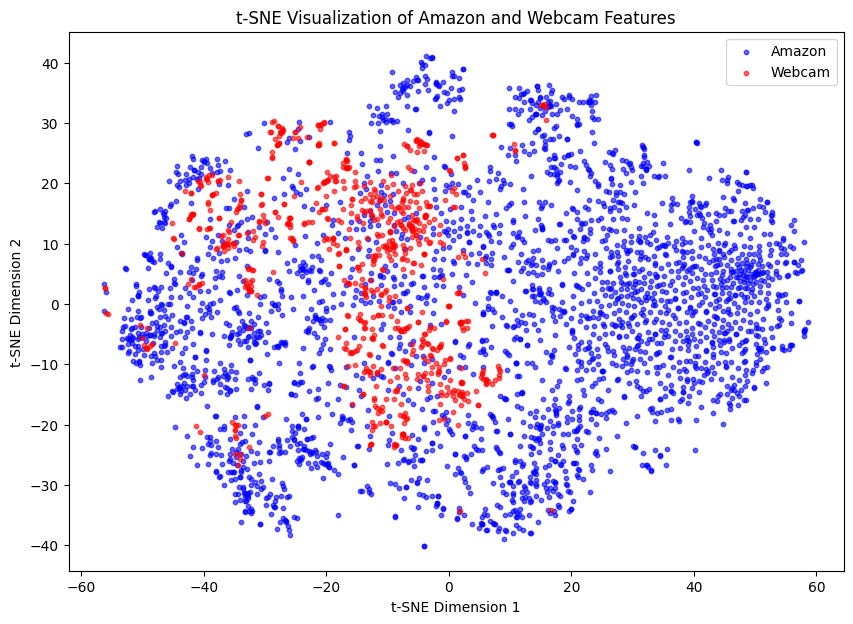

In [ ]:
visualize_features_with_tsne(model, amazon_dataloader, webcam_dataloader, source_label="Amazon", target_label="Webcam")

#### Second experiment A -> D

In [ ]:
# num_classes = len(amazon_dataset.classes)

# model = load_resnet_model(num_classes)

# # Define the loss function and the optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Train the model
# train_model(model, amazon_dataloader, optimizer, criterion, 5)

# # Evaluating on the DSLR data
# evaluate_model(model, dslr_dataloader)

# num_classes = len(amazon_dataset.classes)
num_classes = 31

# model = load_resnet_model(num_classes)
model = BaseModel()
model = model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Get the specific dataloders
amazon_dataloader = load_data(data_path, 'amazon', 64, 'src')
dslr_dataloader = load_data(data_path, 'dslr', 64, 'tar')

# dataloaders = {'src': amazon_dataloader, 'val': webcam_dataloader, 'tar': webcam_dataloader}

# Define the optimizer
param_group = []
learning_rate = 0.0001
momentum = 5e-4
for k, v in model.named_parameters():
    if not k.__contains__('fc'):
        param_group += [{'params': v, 'lr': learning_rate}]
    else:
        param_group += [{'params': v, 'lr': learning_rate * 10}]
optimizer = torch.optim.SGD(param_group, momentum=momentum)

# Train the model
# finetune(model, dataloaders, optimizer)
train_model(model, amazon_dataloader, optimizer, criterion, 5)

# Evaluating on the Webcam data
evaluate_model(model, dslr_dataloader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the wo

Epoch [1/5], Loss: 3.3987


Epoch 2/5: 100%|██████████| 45/45 [00:30<00:00,  1.49it/s]


Epoch [2/5], Loss: 3.3198


Epoch 3/5: 100%|██████████| 45/45 [00:30<00:00,  1.49it/s]


Epoch [3/5], Loss: 3.2475


Epoch 4/5: 100%|██████████| 45/45 [00:29<00:00,  1.52it/s]


Epoch [4/5], Loss: 3.1802


Epoch 5/5: 100%|██████████| 45/45 [00:29<00:00,  1.52it/s]


Epoch [5/5], Loss: 3.1082


Evaluating: 100%|██████████| 7/7 [01:05<00:00,  9.40s/it]

Accuracy: 40.85%


40.848214285714285

#### Feature Visualization A -> D

Extracting features from Amazon...
Extracting features from DSLR...
Applying t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


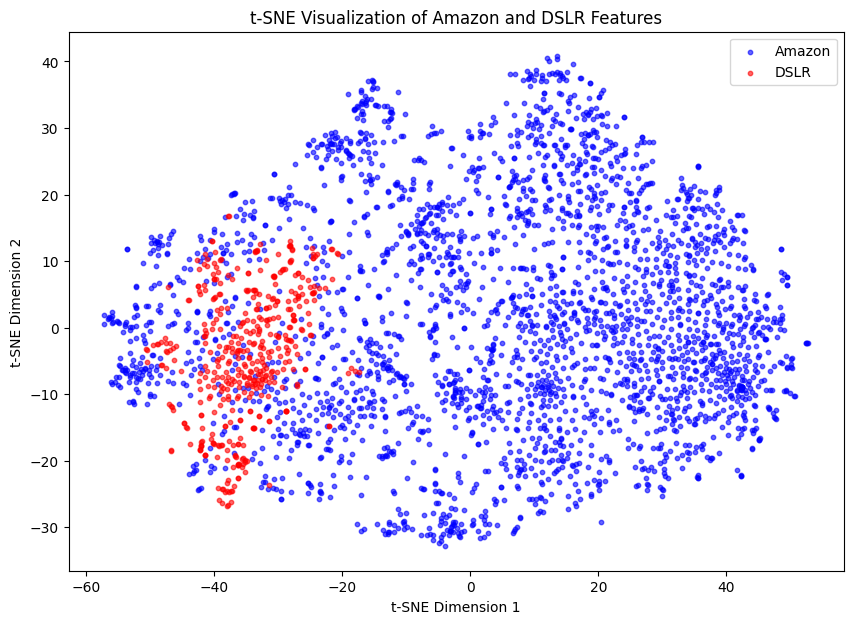

In [ ]:
visualize_features_with_tsne(model, amazon_dataloader, dslr_dataloader, source_label="Amazon", target_label="DSLR")

#### Third experiment W -> A

In [10]:
# num_classes = len(amazon_dataset.classes)

# model = load_resnet_model(num_classes)

# # Define the loss function and the optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Train the model
# train_model(model, webcam_dataloader, optimizer, criterion, 5)

# # Evaluating on the Amazon data
# evaluate_model(model, amazon_dataloader)

# num_classes = len(amazon_dataset.classes)
num_classes = 31

# model = load_resnet_model(num_classes)
model = BaseModel()
model = model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Get the specific dataloders
webcam_dataloader = load_data(data_path, 'webcam', 64, 'src')
amazon_dataloader = load_data(data_path, 'amazon', 64, 'tar')


# Define the optimizer
param_group = []
learning_rate = 0.0001
momentum = 5e-4
for k, v in model.named_parameters():
    if not k.__contains__('fc'):
        param_group += [{'params': v, 'lr': learning_rate}]
    else:
        param_group += [{'params': v, 'lr': learning_rate * 10}]
optimizer = torch.optim.SGD(param_group, momentum=momentum)

# Train the model
# finetune(model, dataloaders, optimizer)
train_model(model, webcam_dataloader, optimizer, criterion, 5)

# Evaluating on the Webcam data
evaluate_model(model, amazon_dataloader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/5: 100%|██████████| 13/13 [03:06<00:00, 14.36s/it]


Epoch [1/5], Loss: 3.4309


Epoch 2/5: 100%|██████████| 13/13 [00:09<00:00,  1.41it/s]


Epoch [2/5], Loss: 3.4208


Epoch 3/5: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


Epoch [3/5], Loss: 3.4074


Epoch 4/5: 100%|██████████| 13/13 [00:09<00:00,  1.34it/s]


Epoch [4/5], Loss: 3.3933


Epoch 5/5: 100%|██████████| 13/13 [00:09<00:00,  1.42it/s]


Epoch [5/5], Loss: 3.3827


Evaluating: 100%|██████████| 44/44 [09:51<00:00, 13.44s/it]

Accuracy: 10.16%


10.15625

#### Feature Visualization W -> A

Extracting features from Webcam...
Extracting features from Amazon...
Applying t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


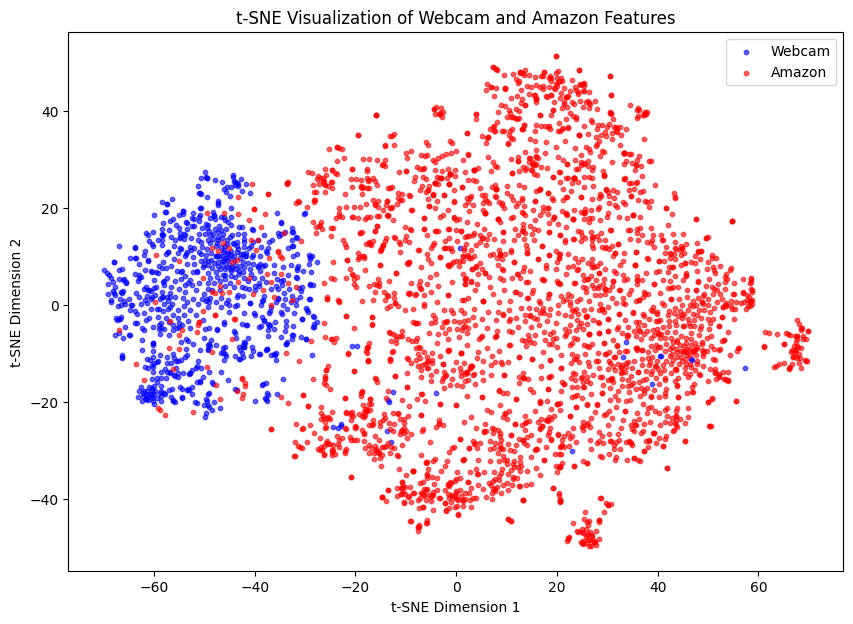

In [ ]:
visualize_features_with_tsne(model, webcam_dataloader, amazon_dataloader, source_label="Webcam", target_label="Amazon")

#### Fourth Experiment W -> D

In [ ]:
# num_classes = len(amazon_dataset.classes)

# model = load_resnet_model(num_classes)

# # Define the loss function and the optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Train the model
# train_model(model, webcam_dataloader, optimizer, criterion, 5)

# # Evaluating on the DSLR data
# evaluate_model(model, dslr_dataloader)

# num_classes = len(amazon_dataset.classes)
num_classes = 31

# model = load_resnet_model(num_classes)
model = TransferModel()
model = model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Get the specific dataloders
webcam_dataloader = load_data(data_path, 'webcam', 64, 'src')
dslr_dataloader = load_data(data_path, 'dslr', 64, 'tar')


# Define the optimizer
param_group = []
learning_rate = 0.0001
momentum = 5e-4
for k, v in model.named_parameters():
    if not k.__contains__('fc'):
        param_group += [{'params': v, 'lr': learning_rate}]
    else:
        param_group += [{'params': v, 'lr': learning_rate * 10}]
optimizer = torch.optim.SGD(param_group, momentum=momentum)

# Train the model
# finetune(model, dataloaders, optimizer)
train_model(model, webcam_dataloader, optimizer, criterion, 5)

# Evaluating on the Webcam data
evaluate_model(model, dslr_dataloader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the wo

Epoch [1/5], Loss: 3.4190


Epoch 2/5: 100%|██████████| 13/13 [00:09<00:00,  1.38it/s]


Epoch [2/5], Loss: 3.3750


Epoch 3/5: 100%|██████████| 13/13 [00:14<00:00,  1.08s/it]


Epoch [3/5], Loss: 3.3386


Epoch 4/5: 100%|██████████| 13/13 [00:10<00:00,  1.28it/s]


Epoch [4/5], Loss: 3.3004


Epoch 5/5: 100%|██████████| 13/13 [00:09<00:00,  1.40it/s]


Epoch [5/5], Loss: 3.2596


Evaluating: 100%|██████████| 7/7 [00:08<00:00,  1.27s/it]

Accuracy: 12.95%


12.946428571428573

#### Feature Visualization W -> D

Extracting features from Webcam...
Extracting features from DSLR...
Applying t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


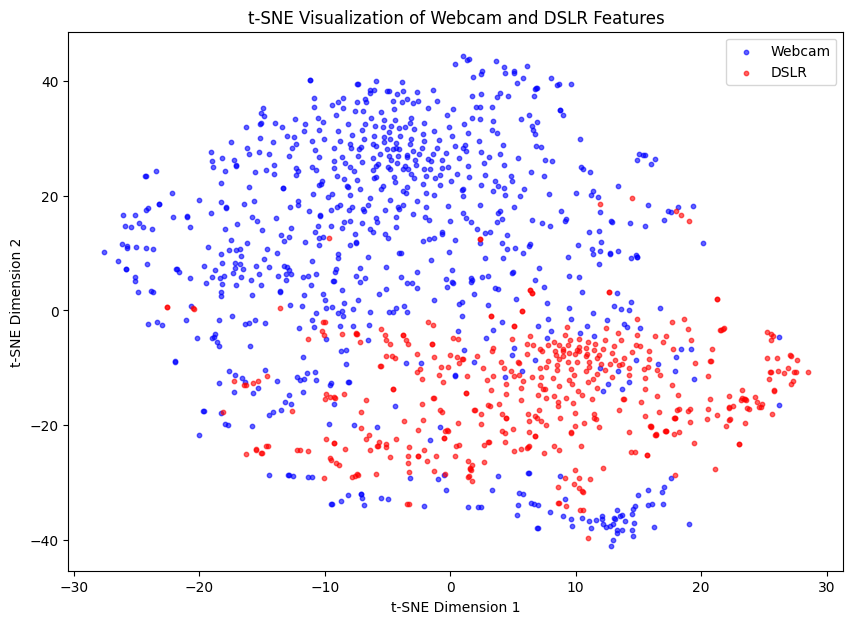

In [ ]:
visualize_features_with_tsne(model, webcam_dataloader, dslr_dataloader, source_label="Webcam", target_label="DSLR")

#### Fifth Experiment D -> A

In [ ]:
# num_classes = len(amazon_dataset.classes)

# model = load_resnet_model(num_classes)

# # Define the loss function and the optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Train the model
# train_model(model, dslr_dataloader, optimizer, criterion, 5)

# # Evaluating on the Amazon data
# evaluate_model(model, amazon_dataloader)

# num_classes = len(amazon_dataset.classes)
num_classes = 31

# model = load_resnet_model(num_classes)
model = TransferModel()
model = model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Get the specific dataloders
dslr_dataloader = load_data(data_path, 'dslr', 64, 'src')
amazon_dataloader = load_data(data_path, 'amazon', 64, 'tar')


# Define the optimizer
param_group = []
learning_rate = 0.0001
momentum = 5e-4
for k, v in model.named_parameters():
    if not k.__contains__('fc'):
        param_group += [{'params': v, 'lr': learning_rate}]
    else:
        param_group += [{'params': v, 'lr': learning_rate * 10}]
optimizer = torch.optim.SGD(param_group, momentum=momentum)

# Train the model
# finetune(model, dataloaders, optimizer)
train_model(model, dslr_dataloader, optimizer, criterion, 5)

# Evaluating on the Webcam data
evaluate_model(model, amazon_dataloader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the wo

Epoch [1/5], Loss: 3.4409


Epoch 2/5: 100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


Epoch [2/5], Loss: 3.3957


Epoch 3/5: 100%|██████████| 8/8 [00:10<00:00,  1.33s/it]


Epoch [3/5], Loss: 3.3598


Epoch 4/5: 100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


Epoch [4/5], Loss: 3.3243


Epoch 5/5: 100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


Epoch [5/5], Loss: 3.2949


Evaluating: 100%|██████████| 44/44 [00:16<00:00,  2.60it/s]

Accuracy: 12.14%


12.144886363636363

#### Feature Visualization D -> A

Extracting features from DSLR...
Extracting features from Amazon...
Applying t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


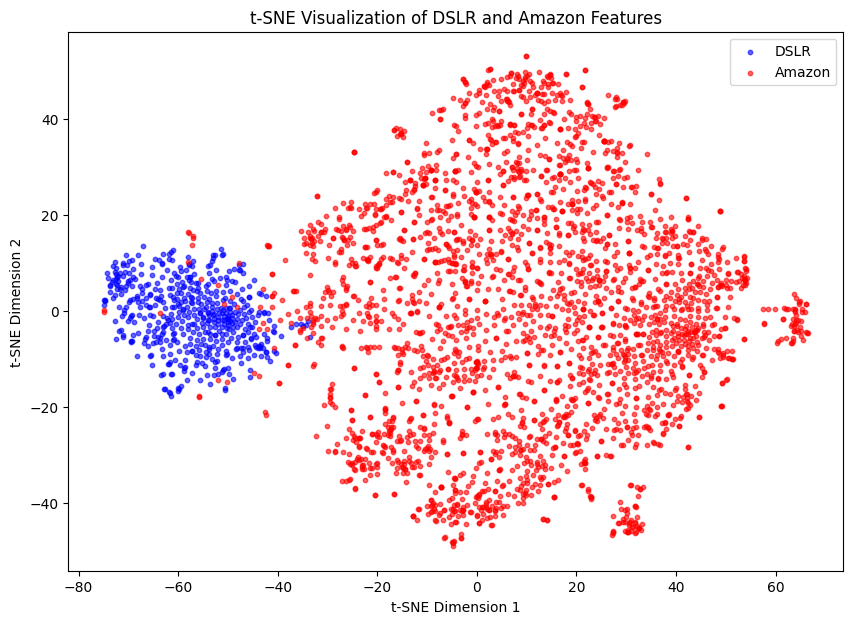

In [ ]:
visualize_features_with_tsne(model, dslr_dataloader, amazon_dataloader, source_label="DSLR", target_label="Amazon")

#### Sixth Experiment D -> W

In [ ]:
# num_classes = len(amazon_dataset.classes)

# model = load_resnet_model(num_classes)

# # Define the loss function and the optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Train the model
# train_model(model, dslr_dataloader, optimizer, criterion, 5)

# # Evaluating on the Webcam data
# evaluate_model(model, webcam_dataloader)

# num_classes = len(amazon_dataset.classes)
num_classes = 31

# model = load_resnet_model(num_classes)
model = TransferModel()
model = model.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Get the specific dataloders
dslr_dataloader = load_data(data_path, 'dslr', 64, 'src')
webcam_dataloader = load_data(data_path, 'webcam', 64, 'tar')


# Define the optimizer
param_group = []
learning_rate = 0.0001
momentum = 5e-4
for k, v in model.named_parameters():
    if not k.__contains__('fc'):
        param_group += [{'params': v, 'lr': learning_rate}]
    else:
        param_group += [{'params': v, 'lr': learning_rate * 10}]
optimizer = torch.optim.SGD(param_group, momentum=momentum)

# Train the model
# finetune(model, dataloaders, optimizer)
train_model(model, dslr_dataloader, optimizer, criterion, 5)

# Evaluating on the Webcam data
evaluate_model(model, webcam_dataloader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the wo

Epoch [1/5], Loss: 3.4292


Epoch 2/5: 100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Epoch [2/5], Loss: 3.3913


Epoch 3/5: 100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


Epoch [3/5], Loss: 3.3554


Epoch 4/5: 100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Epoch [4/5], Loss: 3.3202


Epoch 5/5: 100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


Epoch [5/5], Loss: 3.2940


Evaluating: 100%|██████████| 12/12 [00:06<00:00,  1.75it/s]

Accuracy: 12.24%


12.239583333333332

#### Feature Visualization D -> W

Extracting features from DSLR...
Extracting features from Webcam...
Applying t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


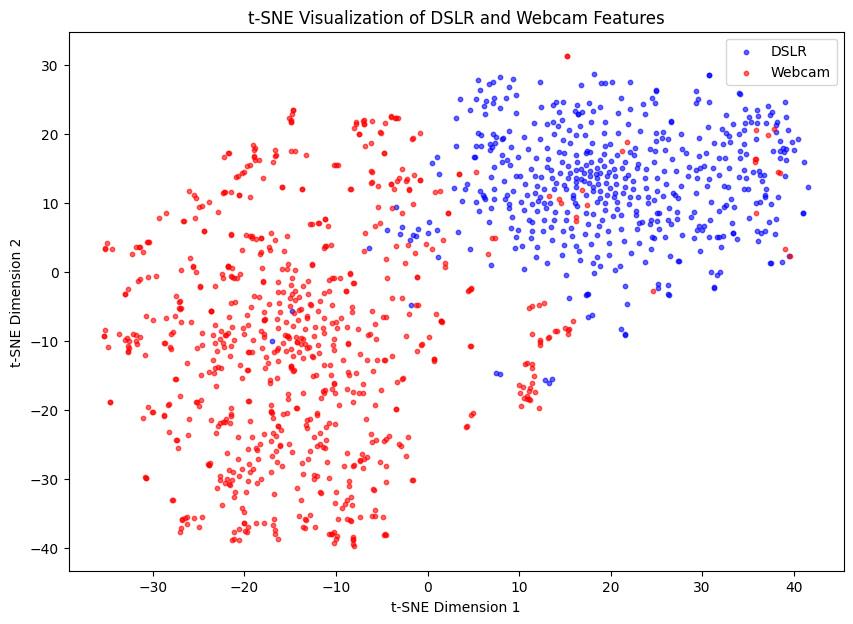

In [ ]:
visualize_features_with_tsne(model, dslr_dataloader, webcam_dataloader, source_label="DSLR", target_label="Webcam")

### Digits Dataset Experiments

#### First experiment M -> U
<!-- A -> W -->

In [ ]:
model_M_to_U = load_resnet_model(num_classes)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_M_to_U.parameters(), lr=0.001)

# Train the model
train_model(model_M_to_U, mnist_train_subset_loader, optimizer, criterion, 5)

# Evaluating on the USPS data
evaluate_model(model_M_to_U, usps_test_subset_loader)

# Training the model on the MNIST dataset
# train_model(model_M_to_U, mnist_train_loader, optimizer, criterion, num_epochs=5)
# train_model(model_M_to_U, mnist_subset_loader, optimizer, criterion, num_epochs=5)

# Evaluating the model on the USPS dataset
# evaluate_model(model_M_to_U, usps_test_loader)

# # Training the model on the Amazon dataset
# train_model(model_A_to_W, amazon_dataloader, optimizer, criterion, num_epochs=5)

# # Evaluating the model on the Webcam dataset
# evaluate_model(model_A_to_W, webcam_dataloader)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 185MB/s]
Epoch 1/5: 100%|██████████| 157/157 [01:47<00:00,  1.46it/s]


Epoch [1/5], Loss: 0.2293


Epoch 2/5: 100%|██████████| 157/157 [01:49<00:00,  1.44it/s]


Epoch [2/5], Loss: 0.0672


Epoch 3/5: 100%|██████████| 157/157 [01:49<00:00,  1.43it/s]


Epoch [3/5], Loss: 0.0581


Epoch 4/5: 100%|██████████| 157/157 [01:49<00:00,  1.44it/s]


Epoch [4/5], Loss: 0.0400


Epoch 5/5: 100%|██████████| 157/157 [01:49<00:00,  1.43it/s]


Epoch [5/5], Loss: 0.0329


Evaluating: 100%|██████████| 16/16 [00:04<00:00,  3.37it/s]

Accuracy: 85.00%


85.0

In [ ]:
# Saving the trained digit model M -> U
# torch.save(model_A_to_W, 'baseline_model_mnist_to_usps.pth')

In [ ]:
# Saving the trained model
# torch.save(model_A_to_W, 'baseline_model_amazon_to_webcam.pth')

#### Loading in the saved model and doing feature visualization

In [ ]:
# Define the feature extractor
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(model.children())[:-1])  # All layers except the final FC layer

    def forward(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)  # Flatten the feature map

# Main function for feature extraction, t-SNE, and visualization
def visualize_features_with_tsne(model, source_dataloader, target_dataloader, source_label="Source", target_label="Target"):
    """
    Visualizes features from source and target datasets using t-SNE.

    Args:
        model (nn.Module): The fine-tuned model to extract features from.
        source_dataloader (DataLoader): DataLoader for the source dataset.
        target_dataloader (DataLoader): DataLoader for the target dataset.
        source_label (str): Label for the source dataset in the plot.
        target_label (str): Label for the target dataset in the plot.
    """
    # Create a feature extractor
    feature_extractor = FeatureExtractor(model).to(device)
    feature_extractor.eval()

    def extract_features(dataloader):
        features = []
        labels = []
        with torch.no_grad():
            for images, lbls in dataloader:
                images = images.to(device)
                outputs = feature_extractor(images)
                features.append(outputs.cpu().numpy())
                labels.append(lbls.numpy())
        return np.concatenate(features), np.concatenate(labels)

    # Extract features for source and target
    print(f"Extracting features from {source_label}...")
    source_features, _ = extract_features(source_dataloader)

    print(f"Extracting features from {target_label}...")
    target_features, _ = extract_features(target_dataloader)

    # Combine features for t-SNE
    features = np.vstack((source_features, target_features))
    domains = np.array([source_label] * len(source_features) + [target_label] * len(target_features))

    # Apply t-SNE
    print("Applying t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    features_2d = tsne.fit_transform(features)

    # Plot t-SNE results
    plt.figure(figsize=(10, 7))
    for domain, color in zip([source_label, target_label], ['blue', 'red']):
        indices = domains == domain
        plt.scatter(features_2d[indices, 0], features_2d[indices, 1], label=domain, alpha=0.6, s=10, c=color)

    plt.title(f"t-SNE Visualization of {source_label} and {target_label} Features")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend()
    plt.show()

# Visualize features
# visualize_features_with_tsne(model_M_to_U, mnist_train_subset_loader, usps_test_subset_loader, source_label="MNIST", target_label="USPS")

#### M -> U Feature Distribution

Extracting features from MNIST...
Extracting features from USPS...
Applying t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


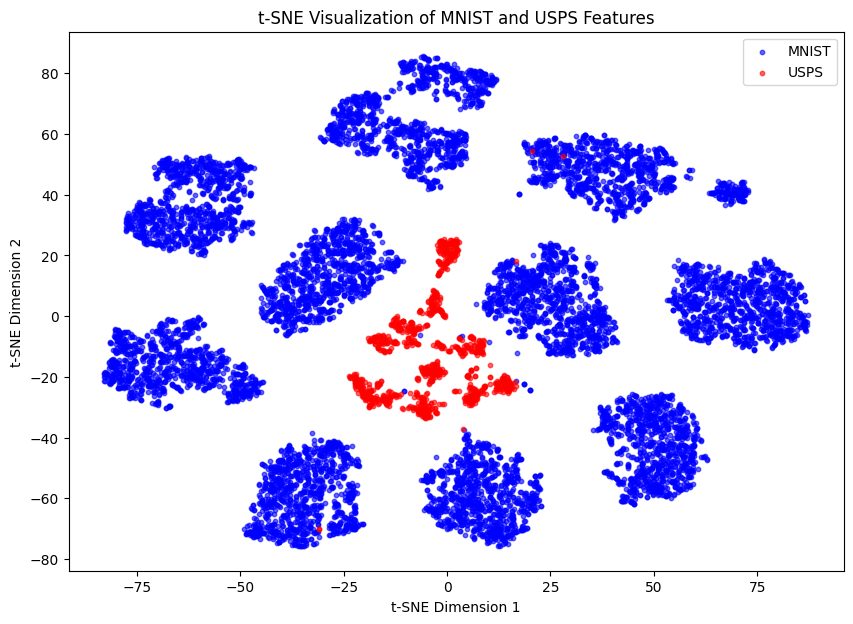

In [ ]:
visualize_features_with_tsne(model_M_to_U, mnist_train_subset_loader, usps_test_subset_loader, source_label="MNIST", target_label="USPS")

#### Second experiment U -> M

In [ ]:
model_U_to_M = load_resnet_model(num_classes)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_U_to_M.parameters(), lr=0.001)

# Train the model
train_model(model_U_to_M, usps_train_subset_loader, optimizer, criterion, 5)

# Evaluating on the USPS data
evaluate_model(model_U_to_M, mnist_test_subset_loader)

Epoch 1/5: 100%|██████████| 79/79 [00:53<00:00,  1.47it/s]


Epoch [1/5], Loss: 0.3111


Epoch 2/5: 100%|██████████| 79/79 [00:53<00:00,  1.47it/s]


Epoch [2/5], Loss: 0.0879


Epoch 3/5: 100%|██████████| 79/79 [00:54<00:00,  1.46it/s]


Epoch [3/5], Loss: 0.0794


Epoch 4/5: 100%|██████████| 79/79 [00:53<00:00,  1.46it/s]


Epoch [4/5], Loss: 0.0254


Epoch 5/5: 100%|██████████| 79/79 [00:53<00:00,  1.47it/s]


Epoch [5/5], Loss: 0.0611


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.55it/s]

Accuracy: 84.04%


84.04

#### U -> M Feature Distribution

Extracting features from USPS...
Extracting features from MNIST...
Applying t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


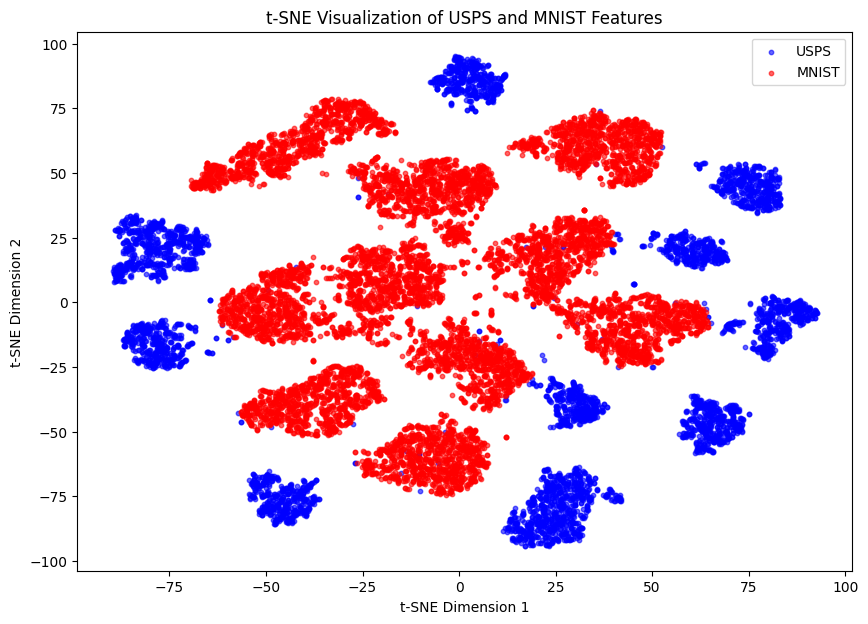

In [ ]:
visualize_features_with_tsne(model_U_to_M, usps_train_subset_loader, mnist_train_subset_loader, source_label="USPS", target_label="MNIST")

#### Third experiment S -> M

In [ ]:
model_S_to_M = load_resnet_model(num_classes)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_S_to_M.parameters(), lr=0.001)

# Train the model
train_model(model_S_to_M, svhn_train_subset_loader, optimizer, criterion, 5)

# Evaluating on the USPS data
evaluate_model(model_S_to_M, mnist_test_subset_loader)

Epoch 1/5: 100%|██████████| 157/157 [01:47<00:00,  1.46it/s]


Epoch [1/5], Loss: 0.7604


Epoch 2/5: 100%|██████████| 157/157 [01:48<00:00,  1.45it/s]


Epoch [2/5], Loss: 0.3420


Epoch 3/5: 100%|██████████| 157/157 [01:49<00:00,  1.44it/s]


Epoch [3/5], Loss: 0.2634


Epoch 4/5: 100%|██████████| 157/157 [01:49<00:00,  1.44it/s]


Epoch [4/5], Loss: 0.2225


Epoch 5/5: 100%|██████████| 157/157 [01:49<00:00,  1.43it/s]


Epoch [5/5], Loss: 0.2025


Evaluating: 100%|██████████| 79/79 [00:22<00:00,  3.52it/s]

Accuracy: 72.98%


72.98

S -> M Feature Distribution

Extracting features from SVHN...
Extracting features from MNIST...
Applying t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


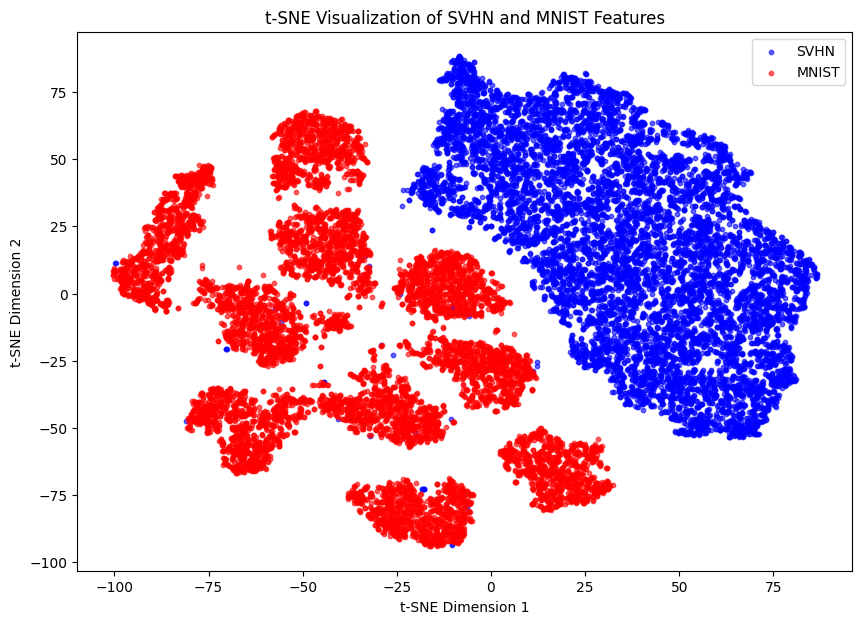

In [ ]:
visualize_features_with_tsne(model_U_to_M, svhn_train_subset_loader, mnist_train_subset_loader, source_label="SVHN", target_label="MNIST")

## DAN Architecture

#### Defining the MMD Loss

In [11]:
# def compute_mmd_loss(source_features, target_features):
#     """
#     Compute the Maximum Mean Discrepancy (MMD) loss between source and target features.
#     """
#     source_mean = torch.mean(source_features, dim=0)
#     target_mean = torch.mean(target_features, dim=0)
#     mmd_loss = torch.norm(source_mean - target_mean, p=2)  # L2 norm
#     return mmd_loss

class MMD_loss(nn.Module):
    def __init__(self, kernel_type='rbf', kernel_mul=2.0, kernel_num=5):
        super(MMD_loss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = None
        self.kernel_type = kernel_type

    def guassian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        n_samples = int(source.size()[0]) + int(target.size()[0])
        total = torch.cat([source, target], dim=0)
        total0 = total.unsqueeze(0).expand(
            int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(
            int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2)
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i)
                          for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp)
                      for bandwidth_temp in bandwidth_list]
        return sum(kernel_val)

    def linear_mmd2(self, f_of_X, f_of_Y):
        loss = 0.0
        delta = f_of_X.float().mean(0) - f_of_Y.float().mean(0)
        loss = delta.dot(delta.T)
        return loss

    def forward(self, source, target):
        if self.kernel_type == 'linear':
            return self.linear_mmd2(source, target)
        elif self.kernel_type == 'rbf':
            batch_size = int(source.size()[0])
            kernels = self.guassian_kernel(
                source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
            XX = torch.mean(kernels[:batch_size, :batch_size])
            YY = torch.mean(kernels[batch_size:, batch_size:])
            XY = torch.mean(kernels[:batch_size, batch_size:])
            YX = torch.mean(kernels[batch_size:, :batch_size])
            loss = torch.mean(XX + YY - XY - YX)
            return loss

#### Creating the DAN class by modifying ResNet backbone

In [15]:
# class DAN(nn.Module):
#     def __init__(self, num_classes):
#         super(DAN, self).__init__()
#         # self.backbone = resnet50()
#         self.backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
#         num_features = self.backbone.fc.in_features
#         self.backbone.fc = nn.Identity()

#         # New classification head
#         self.fc = nn.Sequential(
#             nn.Linear(num_features, 256),
#             nn.ReLU(),
#             nn.Linear(256, num_classes)
#         )

#     def forward(self, x):
#         features = self.backbone(x)
#         outputs = self.fc(features)
#         return features, outputs

class ResNet50Fc(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet50Fc, self).__init__()
        # Load the pre-trained ResNet-50 model
        model_resnet50 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

        # Extract all layers except the final fully connected layer
        self.feature_extractor = nn.Sequential(*list(model_resnet50.children())[:-1])

        # Save the number of features for the output
        self.__in_features = model_resnet50.fc.in_features

    def forward(self, x):
        x = self.feature_extractor(x)  # Extract features
        x = x.view(x.size(0), -1)  # Flatten the feature map
        return x

    def output_num(self):
        return self.__in_features

class DAN(nn.Module):
    def __init__(self,
                 num_class,
                 base_net='resnet50',
                 transfer_loss='mmd',
                 use_bottleneck=True,
                 bottleneck_width=256,
                 width=1024):
        super(DAN, self).__init__()
        if base_net == 'resnet50':
            self.base_network = ResNet50Fc()
            # return
        self.use_bottleneck = use_bottleneck
        self.transfer_loss = transfer_loss
        bottleneck_list = [nn.Linear(self.base_network.output_num(
        ), bottleneck_width), nn.BatchNorm1d(bottleneck_width), nn.ReLU(), nn.Dropout(0.5)]
        self.bottleneck_layer = nn.Sequential(*bottleneck_list)
        classifier_layer_list = [nn.Linear(self.base_network.output_num(), width), nn.ReLU(), nn.Dropout(0.5),
                                 nn.Linear(width, num_class)]
        self.classifier_layer = nn.Sequential(*classifier_layer_list)

        self.bottleneck_layer[0].weight.data.normal_(0, 0.005)
        self.bottleneck_layer[0].bias.data.fill_(0.1)
        for i in range(2):
            self.classifier_layer[i * 3].weight.data.normal_(0, 0.01)
            self.classifier_layer[i * 3].bias.data.fill_(0.0)

    def forward(self, source, target):
        source = self.base_network(source)
        target = self.base_network(target)
        source_clf = self.classifier_layer(source)
        if self.use_bottleneck:
            source = self.bottleneck_layer(source)
            target = self.bottleneck_layer(target)
        transfer_loss = self.adapt_loss(source, target, self.transfer_loss)
        return source_clf, transfer_loss

    def predict(self, x):
        features = self.base_network(x)
        clf = self.classifier_layer(features)
        return clf

    def adapt_loss(self, X, Y, adapt_loss):
        """Compute adaptation loss, currently we support mmd and coral

        Arguments:
            X {tensor} -- source matrix
            Y {tensor} -- target matrix
            adapt_loss {string} -- loss type, 'mmd' or 'coral'. You can add your own loss

        Returns:
            [tensor] -- adaptation loss tensor
        """
        if adapt_loss == 'mmd':
            mmd_loss = MMD_loss()
            loss = mmd_loss(X, Y)
        return loss

#### DAN training loop

In [13]:
# def train_dan(model, source_loader, target_loader, criterion, optimizer, device, num_epochs):
#     """
#     Train the DAN model with classification and MMD loss.
#     """
#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
#         correct = 0
#         total = 0

#         # Determine the dataloader with fewer samples
#         num_iterations = min(len(source_loader), len(target_loader))

#         source_iter = iter(source_loader)
#         target_iter = iter(target_loader)

#         for i in tqdm(range(num_iterations), desc=f"Epoch {epoch + 1}/{num_epochs}"):
#             # Get source and target batches
#             try:
#                 source_images, source_labels = next(source_iter)
#                 target_images, _ = next(target_iter)  # Target labels not used
#             except StopIteration:
#                 # If either iterator is exhausted, break the loop
#                 break

#             source_images, source_labels = source_images.to(device), source_labels.to(device)
#             target_images = target_images.to(device)

#             # Forward pass
#             source_features, source_logits = model(source_images)
#             target_features, _ = model(target_images)

#             # Compute losses
#             classification_loss = criterion(source_logits, source_labels)
#             mmd_loss = compute_mmd_loss(source_features, target_features)
#             total_loss = classification_loss + mmd_loss  # Combine losses

#             # Backward pass
#             optimizer.zero_grad()
#             total_loss.backward()
#             optimizer.step()

#             # Track metrics
#             running_loss += total_loss.item() * source_images.size(0)
#             _, preds = torch.max(source_logits, 1)
#             correct += (preds == source_labels).sum().item()
#             total += source_labels.size(0)

#         epoch_loss = running_loss / total
#         epoch_accuracy = 100.0 * correct / total

#         print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

# def evaluate_model_dan(model, dataloader):
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for images, labels in dataloader:
#             images, labels = images.to(device), labels.to(device)
#             # Forward pass - get the second element of the tuple which are the outputs
#             _, outputs = model(images)
#             _, predicted = torch.max(outputs, 1)

#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     accuracy = 100.0 * correct / total
#     return accuracy

def evaluate(model, dataloader, criterion):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0

    # Progress bar for evaluation
    pbar = tqdm(dataloader, desc='Evaluating', leave=False)
    with torch.no_grad():
        for data, labels in pbar:
            data, labels = data.cuda(), labels.cuda()

            # Forward pass
            preds, _ = model(data, data)  # Pass target data twice since no transfer loss is needed
            loss = criterion(preds, labels)

            # Predictions
            _, predicted = torch.max(preds, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()

            # Update progress bar
            pbar.set_postfix(loss=f'{loss.item():.4f}', accuracy=f'{(correct / total)*100:.4f}')

    accuracy = (correct / total)*100
    return accuracy


def train_dan(dataloaders, model, optimizer, criterion, lamb, n_epoch, early_stop):
    """
    Train the domain adaptation model using source and target datasets.

    Args:
        dataloaders (dict): Contains 'src' and 'tar' DataLoaders for source and target train datasets.
        model (nn.Module): The domain adaptation model.
        optimizer (torch.optim.Optimizer): Optimizer for model training.
        criterion (Loss): Classification loss function (e.g., CrossEntropyLoss).
        lamb (float): Weight for the transfer loss.
        n_epoch (int): Number of training epochs.
        early_stop (int): Early stopping criterion (number of epochs without improvement).
    """
    source_loader = dataloaders['src']
    target_train_loader = dataloaders['tar']
    len_source_loader = len(source_loader)
    len_target_loader = len(target_train_loader)
    best_acc = 0
    stop = 0
    n_batch = min(len_source_loader, len_target_loader)

    for e in range(n_epoch):
        stop += 1
        train_loss_clf, train_loss_transfer, train_loss_total = 0, 0, 0
        model.train()

        # Progress bar for batches
        pbar = tqdm(zip(source_loader, target_train_loader), desc=f'Epoch [{e + 1}/{n_epoch}]', total=n_batch, leave=False)
        for src, tar in pbar:
            data_source, label_source = src
            data_target, _ = tar
            data_source, label_source = data_source.cuda(), label_source.cuda()
            data_target = data_target.cuda()

            # Forward pass
            optimizer.zero_grad()
            label_source_pred, transfer_loss = model(data_source, data_target)
            clf_loss = criterion(label_source_pred, label_source)
            loss = clf_loss + lamb * transfer_loss

            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()

            # Update running losses
            train_loss_clf += clf_loss.item()
            train_loss_transfer += transfer_loss.item()
            train_loss_total += loss.item()

            # Update progress bar
            pbar.set_postfix(
                cls_loss=f'{clf_loss.item():.4f}',
                transfer_loss=f'{transfer_loss.item():.4f}',
                total_loss=f'{loss.item():.4f}'
            )

        # Calculate accuracy on the target test set
        acc = evaluate(model, dataloaders['tar'], criterion)

        print(f'Epoch: [{e + 1:2d}/{n_epoch}], cls_loss: {train_loss_clf/n_batch:.4f}, '
              f'transfer_loss: {train_loss_transfer/n_batch:.4f}, '
              f'total_loss: {train_loss_total/n_batch:.4f}, acc: {acc:.4f}')

        # Save best model
        if best_acc < acc:
            best_acc = acc
            # torch.save(model.state_dict(), 'trans_model.pkl')
            stop = 0
        if stop >= early_stop:
            print("Early stopping triggered.")
            break


### Office-31 Dataset Experiments

#### First Experiment A -> W

In [16]:
# num_classes = len(amazon_dataset.classes)

# model = DAN(num_classes).to(device)

# # Define the loss, optimizer, and DataLoaders
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# source_loader = amazon_dataloader
# target_loader = webcam_dataloader

# # Train the DAN model
# train_dan(model, source_loader, target_loader, criterion, optimizer, device, num_epochs=5)

# # Evaluate on the target domain
# val_accuracy = evaluate_model_dan(model, webcam_dataloader)
# print(f"Target Domain Evaluation - Accuracy: {val_accuracy:.2f}%")

# visualize_features_with_tsne(model, amazon_dataloader, webcam_dataloader, source_label="Amazon", target_label="Webcam")

transfer_loss = 'mmd'
learning_rate = 0.0001
n_class = 31
transfer_model = DAN(n_class, transfer_loss=transfer_loss, base_net='resnet50').cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD([
    {'params': transfer_model.base_network.parameters()},
    {'params': transfer_model.bottleneck_layer.parameters(), 'lr': 10 * learning_rate},
    {'params': transfer_model.classifier_layer.parameters(), 'lr': 10 * learning_rate},
], lr=learning_rate, momentum=0.9, weight_decay=5e-4)

n_epoch = 5
early_stop = 5
lamb = 0.5

amazon_loader = load_data(data_path, 'amazon', 64, 'src')
webcam_loader = load_data(data_path, 'webcam', 64, 'tar')
dataloaders = {'src': amazon_loader, 'tar': webcam_loader}
train_dan(dataloaders, transfer_model, optimizer, criterion, lamb, n_epoch, early_stop=3)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                                                         

Epoch: [ 1/5], cls_loss: 3.4353, transfer_loss: 0.0809, total_loss: 3.4757, acc: 2.0833


Epoch: [ 2/5], cls_loss: 3.4339, transfer_loss: 0.0825, total_loss: 3.4752, acc: 2.9948


Epoch: [ 3/5], cls_loss: 3.4279, transfer_loss: 0.0825, total_loss: 3.4692, acc: 5.9896


Epoch: [ 4/5], cls_loss: 3.4240, transfer_loss: 0.0822, total_loss: 3.4651, acc: 8.3333


Epoch: [ 5/5], cls_loss: 3.4220, transfer_loss: 0.0821, total_loss: 3.4630, acc: 10.9375


Extracting features from Amazon...
Extracting features from Webcam...
Applying t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


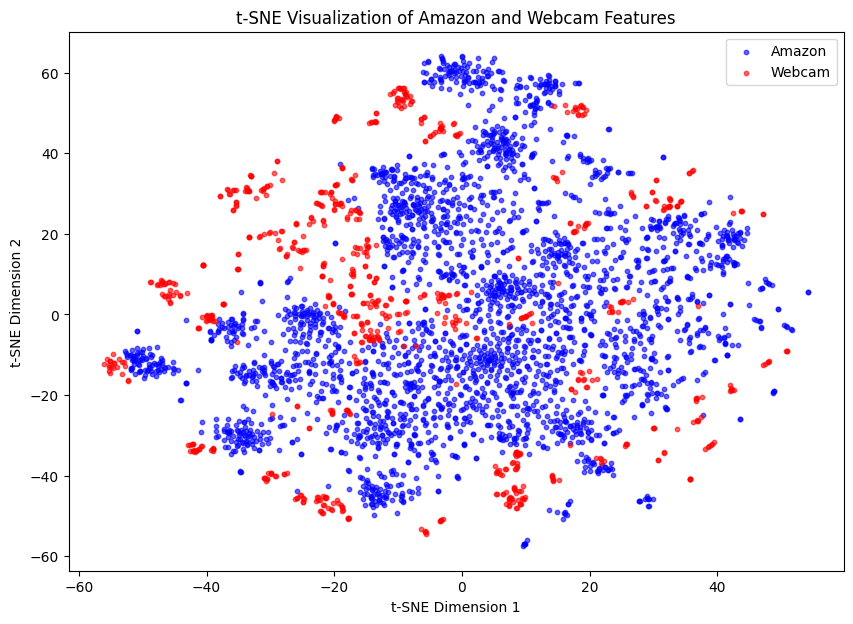

In [17]:
visualize_features_with_tsne(transfer_model, amazon_loader, webcam_loader, source_label="Amazon", target_label="Webcam")

#### DAN Second Experiment A -> D

In [18]:
transfer_loss = 'mmd'
learning_rate = 0.0001
n_class = 31
transfer_model = DAN(n_class, transfer_loss=transfer_loss, base_net='resnet50').cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD([
    {'params': transfer_model.base_network.parameters()},
    {'params': transfer_model.bottleneck_layer.parameters(), 'lr': 10 * learning_rate},
    {'params': transfer_model.classifier_layer.parameters(), 'lr': 10 * learning_rate},
], lr=learning_rate, momentum=0.9, weight_decay=5e-4)

n_epoch = 5
early_stop = 5
lamb = 0.5

amazon_loader = load_data(data_path, 'amazon', 64, 'src')
dslr_loader = load_data(data_path, 'dslr', 64, 'tar')
dataloaders = {'src': amazon_loader, 'tar': dslr_loader}
train_dan(dataloaders, transfer_model, optimizer, criterion, lamb, n_epoch, early_stop=3)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch: [ 1/5], cls_loss: 3.4362, transfer_loss: 0.0836, total_loss: 3.4780, acc: 4.2411


Epoch: [ 2/5], cls_loss: 3.4289, transfer_loss: 0.0818, total_loss: 3.4698, acc: 4.9107


Epoch: [ 3/5], cls_loss: 3.4311, transfer_loss: 0.0814, total_loss: 3.4718, acc: 6.2500


Epoch: [ 4/5], cls_loss: 3.4303, transfer_loss: 0.0824, total_loss: 3.4715, acc: 6.9196


Epoch: [ 5/5], cls_loss: 3.4268, transfer_loss: 0.0850, total_loss: 3.4693, acc: 7.8125


Extracting features from Amazon...
Extracting features from DSLR...
Applying t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


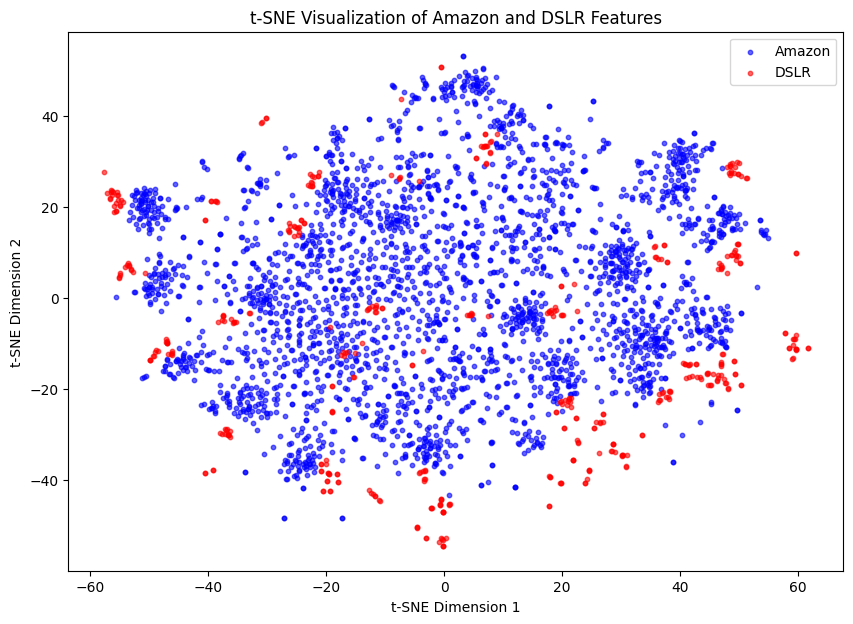

In [19]:
visualize_features_with_tsne(transfer_model, amazon_loader, dslr_loader, source_label="Amazon", target_label="DSLR")

#### DAN Third Experiment W -> A

In [ ]:
transfer_loss = 'mmd'
learning_rate = 0.0001
n_class = 31
transfer_model = DAN(n_class, transfer_loss=transfer_loss, base_net='resnet50').cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD([
    {'params': transfer_model.base_network.parameters()},
    {'params': transfer_model.bottleneck_layer.parameters(), 'lr': 10 * learning_rate},
    {'params': transfer_model.classifier_layer.parameters(), 'lr': 10 * learning_rate},
], lr=learning_rate, momentum=0.9, weight_decay=5e-4)

n_epoch = 5
early_stop = 5
lamb = 0.5

webcam_loader = load_data(data_path, 'webcam', 64, 'src')
amazon_loader = load_data(data_path, 'amazon', 64, 'tar')
dataloaders = {'src': webcam_loader, 'tar': amazon_loader}
train_dan(dataloaders, transfer_model, optimizer, criterion, lamb, n_epoch, early_stop=3)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch: [ 1/5], cls_loss: 3.4316, transfer_loss: 0.0854, total_loss: 3.4743, acc: 4.9716


Epoch: [ 2/5], cls_loss: 3.4257, transfer_loss: 0.0865, total_loss: 3.4690, acc: 6.4631


Epoch: [ 3/5], cls_loss: 3.4188, transfer_loss: 0.0848, total_loss: 3.4612, acc: 8.4162


Epoch: [ 4/5], cls_loss: 3.4079, transfer_loss: 0.0863, total_loss: 3.4510, acc: 9.0909


Evaluating:  16%|█▌        | 7/44 [00:04<00:16,  2.19it/s, accuracy=0.8929, loss=3.4287]

Extracting features from Webcam...
Extracting features from Amazon...
Applying t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


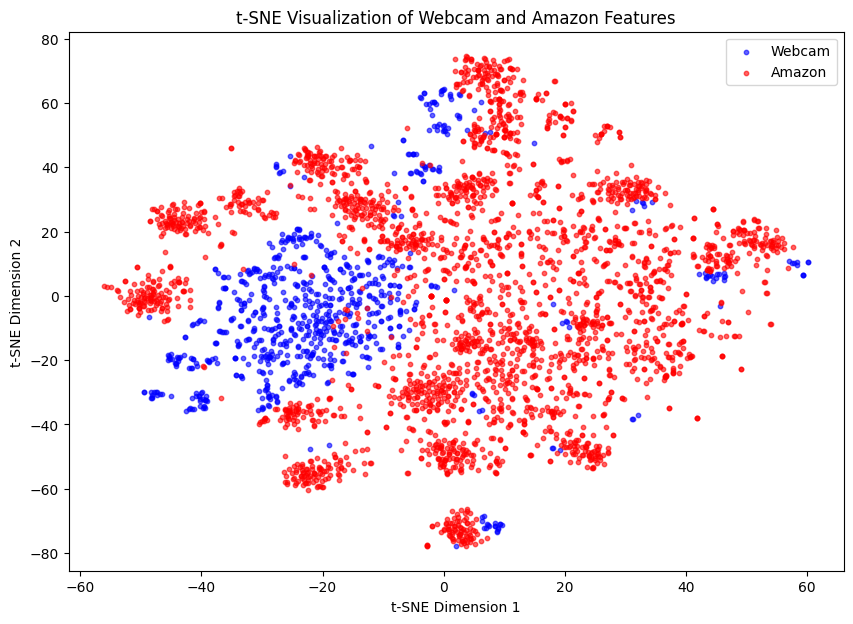

In [21]:
visualize_features_with_tsne(transfer_model, webcam_loader, amazon_loader, source_label="Webcam", target_label="Amazon")

#### DAN Fourth Experiment W -> D

In [22]:
transfer_loss = 'mmd'
learning_rate = 0.0001
n_class = 31
transfer_model = DAN(n_class, transfer_loss=transfer_loss, base_net='resnet50').cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD([
    {'params': transfer_model.base_network.parameters()},
    {'params': transfer_model.bottleneck_layer.parameters(), 'lr': 10 * learning_rate},
    {'params': transfer_model.classifier_layer.parameters(), 'lr': 10 * learning_rate},
], lr=learning_rate, momentum=0.9, weight_decay=5e-4)

n_epoch = 5
early_stop = 5
lamb = 0.5

webcam_loader = load_data(data_path, 'webcam', 64, 'src')
dslr_loader = load_data(data_path, 'dslr', 64, 'tar')
dataloaders = {'src': webcam_loader, 'tar': dslr_loader}
train_dan(dataloaders, transfer_model, optimizer, criterion, lamb, n_epoch, early_stop=3)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                                                       

Epoch: [ 1/5], cls_loss: 3.4357, transfer_loss: 0.0809, total_loss: 3.4761, acc: 3.1250


Epoch: [ 2/5], cls_loss: 3.4313, transfer_loss: 0.0824, total_loss: 3.4726, acc: 4.6875


Epoch: [ 3/5], cls_loss: 3.4301, transfer_loss: 0.0833, total_loss: 3.4717, acc: 5.8036


Epoch: [ 4/5], cls_loss: 3.4270, transfer_loss: 0.0817, total_loss: 3.4678, acc: 8.0357


Epoch: [ 5/5], cls_loss: 3.4205, transfer_loss: 0.0819, total_loss: 3.4615, acc: 9.3750


Extracting features from Webcam...
Extracting features from DSLR...
Applying t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


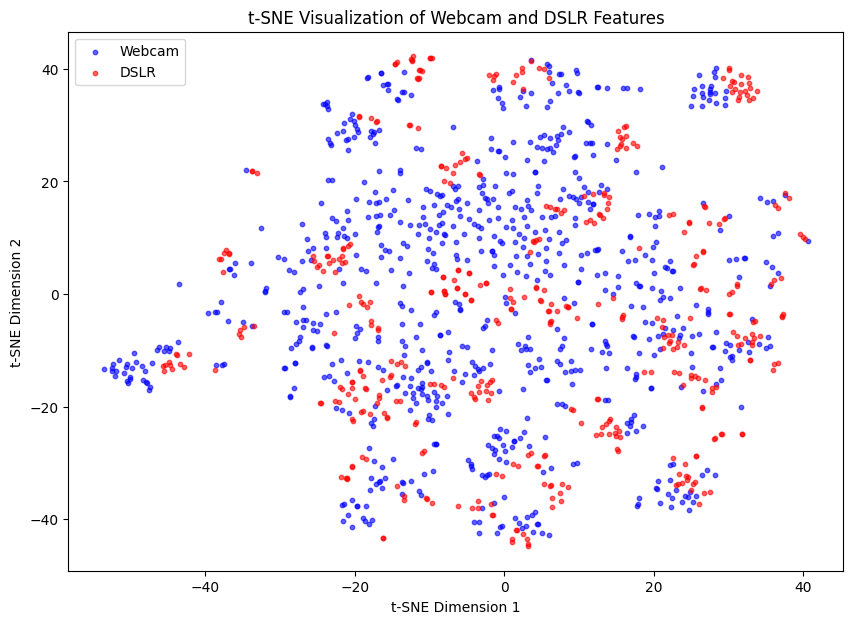

In [23]:
visualize_features_with_tsne(transfer_model, webcam_loader, dslr_loader, source_label="Webcam", target_label="DSLR")

#### DAN Fifth Experiment D -> A

In [24]:
transfer_loss = 'mmd'
learning_rate = 0.0001
n_class = 31
transfer_model = DAN(n_class, transfer_loss=transfer_loss, base_net='resnet50').cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD([
    {'params': transfer_model.base_network.parameters()},
    {'params': transfer_model.bottleneck_layer.parameters(), 'lr': 10 * learning_rate},
    {'params': transfer_model.classifier_layer.parameters(), 'lr': 10 * learning_rate},
], lr=learning_rate, momentum=0.9, weight_decay=5e-4)

n_epoch = 5
early_stop = 5
lamb = 0.5

dslr_loader = load_data(data_path, 'dslr', 64, 'src')
amazon_loader = load_data(data_path, 'amazon', 64, 'tar')
dataloaders = {'src': dslr_loader, 'tar': amazon_loader}
train_dan(dataloaders, transfer_model, optimizer, criterion, lamb, n_epoch, early_stop=3)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                                                         

Epoch: [ 1/5], cls_loss: 3.4323, transfer_loss: 0.0821, total_loss: 3.4734, acc: 3.5866


Epoch: [ 2/5], cls_loss: 3.4263, transfer_loss: 0.0816, total_loss: 3.4671, acc: 4.5455


Epoch: [ 3/5], cls_loss: 3.4236, transfer_loss: 0.0827, total_loss: 3.4650, acc: 6.3920


Epoch: [ 4/5], cls_loss: 3.4147, transfer_loss: 0.0824, total_loss: 3.4559, acc: 8.5938


Epoch: [ 5/5], cls_loss: 3.4060, transfer_loss: 0.0825, total_loss: 3.4473, acc: 8.8423


Extracting features from DSLR...
Extracting features from Amazon...
Applying t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


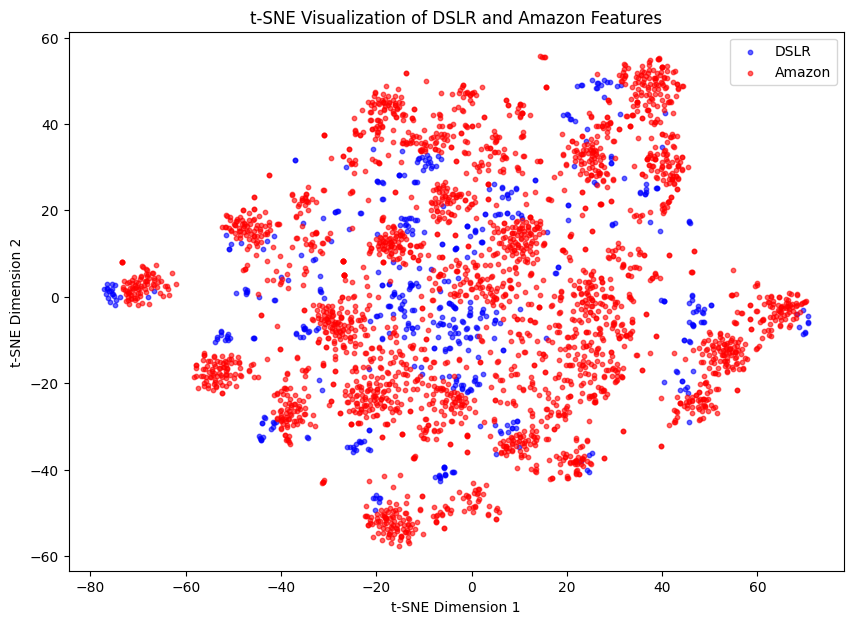

In [25]:
visualize_features_with_tsne(transfer_model, dslr_loader, amazon_loader, source_label="DSLR", target_label="Amazon")

#### DAN Sixth Experiment D -> W

In [26]:
transfer_loss = 'mmd'
learning_rate = 0.0001
n_class = 31
transfer_model = DAN(n_class, transfer_loss=transfer_loss, base_net='resnet50').cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD([
    {'params': transfer_model.base_network.parameters()},
    {'params': transfer_model.bottleneck_layer.parameters(), 'lr': 10 * learning_rate},
    {'params': transfer_model.classifier_layer.parameters(), 'lr': 10 * learning_rate},
], lr=learning_rate, momentum=0.9, weight_decay=5e-4)

n_epoch = 5
early_stop = 5
lamb = 0.5

dslr_loader = load_data(data_path, 'dslr', 64, 'src')
webcam_loader = load_data(data_path, 'webcam', 64, 'tar')
dataloaders = {'src': dslr_loader, 'tar': webcam_loader}
train_dan(dataloaders, transfer_model, optimizer, criterion, lamb, n_epoch, early_stop=3)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                                                         

Epoch: [ 1/5], cls_loss: 3.4361, transfer_loss: 0.0814, total_loss: 3.4768, acc: 3.2552


Epoch: [ 2/5], cls_loss: 3.4322, transfer_loss: 0.0815, total_loss: 3.4729, acc: 3.6458


Epoch: [ 3/5], cls_loss: 3.4246, transfer_loss: 0.0823, total_loss: 3.4658, acc: 4.9479


Epoch: [ 4/5], cls_loss: 3.4182, transfer_loss: 0.0820, total_loss: 3.4593, acc: 6.3802


Epoch: [ 5/5], cls_loss: 3.4115, transfer_loss: 0.0830, total_loss: 3.4530, acc: 8.7240


Extracting features from DSLR...
Extracting features from Webcam...
Applying t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


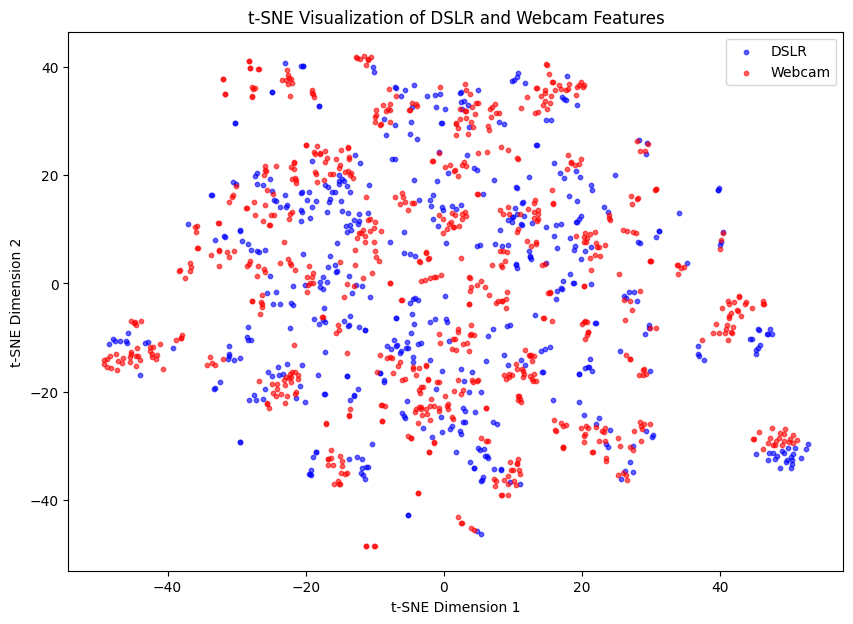

In [27]:
visualize_features_with_tsne(transfer_model, dslr_loader, webcam_loader, source_label="DSLR", target_label="Webcam")

### Digits Datasets Experiments

#### DAN first experiment M->U

In [30]:
# # Initialize the model
# num_classes = 10  # Number of classes in MNIST/USPS
# model = DAN(num_classes).to(device)

# # Define the loss, optimizer, and DataLoaders
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# # Subset loaders for testing
# source_loader = mnist_train_subset_loader
# target_loader = usps_train_subset_loader

# # Train the DAN model
# train_dan(model, source_loader, target_loader, criterion, optimizer, device, num_epochs=10)

# # Evaluate the model on target domain
# val_accuracy = evaluate_model_dan(model, usps_test_subset_loader)
# print(f"Target Domain Evaluation - Accuracy: {val_accuracy:.2f}%")

transfer_loss = 'mmd'
learning_rate = 0.0001
n_class = 31
transfer_model = DAN(n_class, transfer_loss=transfer_loss, base_net='resnet50').cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD([
    {'params': transfer_model.base_network.parameters()},
    {'params': transfer_model.bottleneck_layer.parameters(), 'lr': 10 * learning_rate},
    {'params': transfer_model.classifier_layer.parameters(), 'lr': 10 * learning_rate},
], lr=learning_rate, momentum=0.9, weight_decay=5e-4)

n_epoch = 5
early_stop = 5
lamb = 0.5

dataloaders = {'src': mnist_train_subset_loader, 'tar': usps_train_subset_loader}
train_dan(dataloaders, transfer_model, optimizer, criterion, lamb, n_epoch, early_stop=3)

# Evaluating
val_accuracy = evaluate(transfer_model, usps_test_subset_loader, criterion)
print(f"Target Domain Evaluation - Accuracy: {val_accuracy:.2f}%")


Epoch: [ 1/5], cls_loss: 3.3152, transfer_loss: 0.0857, total_loss: 3.3581, acc: 15.0200


Epoch: [ 2/5], cls_loss: 2.7449, transfer_loss: 0.0851, total_loss: 2.7875, acc: 28.4000


Epoch: [ 3/5], cls_loss: 2.2638, transfer_loss: 0.0854, total_loss: 2.3065, acc: 34.7000


Epoch: [ 4/5], cls_loss: 2.0200, transfer_loss: 0.0853, total_loss: 2.0626, acc: 35.7400


Epoch: [ 5/5], cls_loss: 1.7333, transfer_loss: 0.0849, total_loss: 1.7757, acc: 37.3400


Target Domain Evaluation - Accuracy: 34.70%


#### DAN M->U Feature Alignment check

Extracting features from MNIST...
Extracting features from USPS...
Applying t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


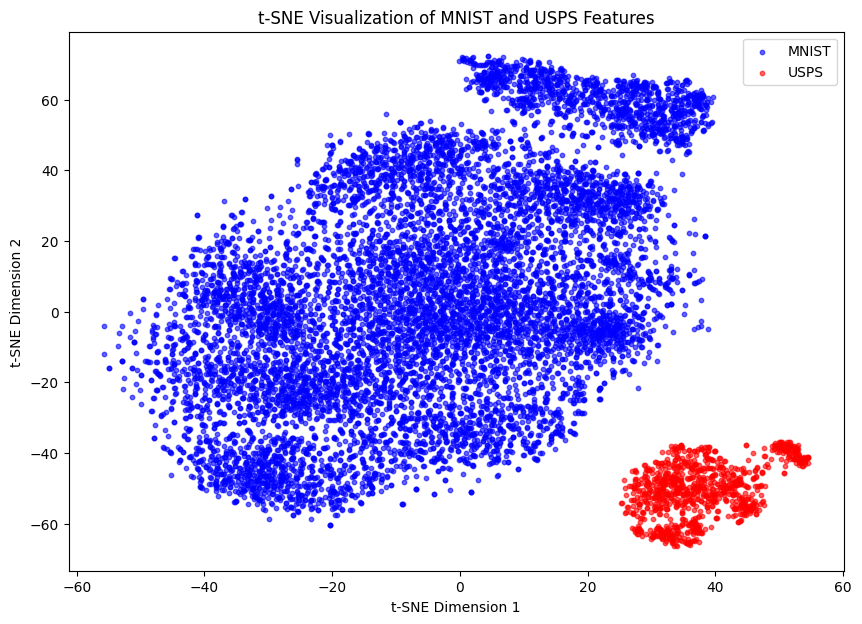

In [31]:
visualize_features_with_tsne(transfer_model, mnist_train_subset_loader, usps_test_subset_loader, source_label="MNIST", target_label="USPS")

#### DAN second experiment U -> M

In [ ]:
# Initialize the model
# num_classes = 10  # Number of classes in MNIST/USPS
# model = DAN(num_classes).to(device)

# # Define the loss, optimizer, and DataLoaders
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# # Subset loaders for testing
# source_loader = usps_train_subset_loader
# target_loader = mnist_train_subset_loader

# # Train the DAN model
# train_dan(model, source_loader, target_loader, criterion, optimizer, device, num_epochs=10)

# # Evaluate the model on target domain
# val_accuracy = evaluate_model_dan(model, mnist_test_subset_loader)
# print(f"Target Domain Evaluation - Accuracy: {val_accuracy:.2f}%")

transfer_loss = 'mmd'
learning_rate = 0.0001
n_class = 31
transfer_model = DAN(n_class, transfer_loss=transfer_loss, base_net='resnet50').cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD([
    {'params': transfer_model.base_network.parameters()},
    {'params': transfer_model.bottleneck_layer.parameters(), 'lr': 10 * learning_rate},
    {'params': transfer_model.classifier_layer.parameters(), 'lr': 10 * learning_rate},
], lr=learning_rate, momentum=0.9, weight_decay=5e-4)

n_epoch = 5
early_stop = 5
lamb = 0.5

dataloaders = {'src': usps_train_subset_loader, 'tar': mnist_train_subset_loader}
train_dan(dataloaders, transfer_model, optimizer, criterion, lamb, n_epoch, early_stop=3)

# Evaluating
val_accuracy = evaluate(transfer_model, mnist_test_subset_loader, criterion)
print(f"Target Domain Evaluation - Accuracy: {val_accuracy:.2f}%")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: [ 1/5], cls_loss: 2.6075, transfer_loss: 0.0858, total_loss: 2.6504, acc: 19.6500


Epoch: [ 2/5], cls_loss: 1.6980, transfer_loss: 0.0862, total_loss: 1.7411, acc: 37.6500


Epoch: [ 3/5], cls_loss: 1.1928, transfer_loss: 0.0862, total_loss: 1.2359, acc: 50.6200


Epoch: [ 4/5], cls_loss: 0.7415, transfer_loss: 0.0866, total_loss: 0.7848, acc: 42.7800


Epoch: [ 5/5], cls_loss: 0.4496, transfer_loss: 0.0866, total_loss: 0.4929, acc: 37.0600


Target Domain Evaluation - Accuracy: 38.54%


#### DAN U -> M Feature Alignment Check

Extracting features from USPS...
Extracting features from MNIST...
Applying t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


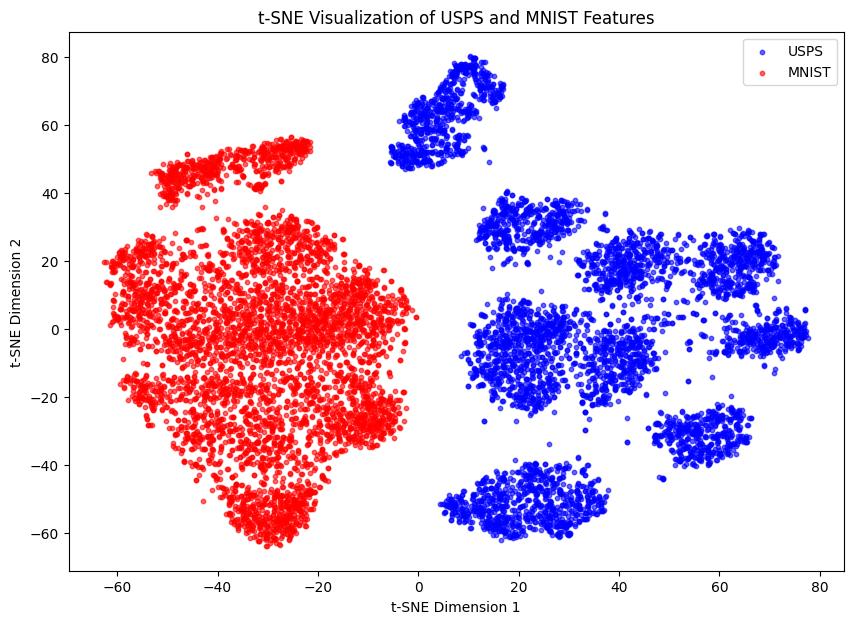

In [ ]:
visualize_features_with_tsne(transfer_model, usps_train_subset_loader, mnist_test_subset_loader, source_label="USPS", target_label="MNIST")

#### DAN third experiment S -> M

In [ ]:
# Initialize the model
# num_classes = 10  # Number of classes in MNIST/USPS
# model = DAN(num_classes).to(device)

# # Define the loss, optimizer, and DataLoaders
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# # Subset loaders for testing
# source_loader = svhn_train_subset_loader
# target_loader = mnist_train_subset_loader

# # Train the DAN model
# train_dan(model, source_loader, target_loader, criterion, optimizer, device, num_epochs=10)

# # Evaluate the model on target domain
# val_accuracy = evaluate_model_dan(model, mnist_test_subset_loader)
# print(f"Target Domain Evaluation - Accuracy: {val_accuracy:.2f}%")

transfer_loss = 'mmd'
learning_rate = 0.0001
n_class = 31
transfer_model = DAN(n_class, transfer_loss=transfer_loss, base_net='resnet50').cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD([
    {'params': transfer_model.base_network.parameters()},
    {'params': transfer_model.bottleneck_layer.parameters(), 'lr': 10 * learning_rate},
    {'params': transfer_model.classifier_layer.parameters(), 'lr': 10 * learning_rate},
], lr=learning_rate, momentum=0.9, weight_decay=5e-4)

n_epoch = 5
early_stop = 5
lamb = 0.5

dataloaders = {'src': svhn_train_subset_loader, 'tar': mnist_train_subset_loader}
train_dan(dataloaders, transfer_model, optimizer, criterion, lamb, n_epoch, early_stop=3)

# Evaluating
val_accuracy = evaluate(transfer_model, mnist_test_subset_loader, criterion)
print(f"Target Domain Evaluation - Accuracy: {val_accuracy:.2f}%")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: [ 1/5], cls_loss: 2.4736, transfer_loss: 0.0834, total_loss: 2.5153, acc: 14.1000


Epoch: [ 2/5], cls_loss: 2.2110, transfer_loss: 0.0829, total_loss: 2.2524, acc: 11.3800


Epoch: [ 3/5], cls_loss: 2.1155, transfer_loss: 0.0826, total_loss: 2.1568, acc: 24.3900


Epoch: [ 4/5], cls_loss: 1.9761, transfer_loss: 0.0826, total_loss: 2.0174, acc: 21.2300


Epoch: [ 5/5], cls_loss: 1.8031, transfer_loss: 0.0830, total_loss: 1.8446, acc: 33.4600


Target Domain Evaluation - Accuracy: 34.08%


#### DAN S -> M Feature Alignment Check

Extracting features from SVHN...
Extracting features from MNIST...
Applying t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


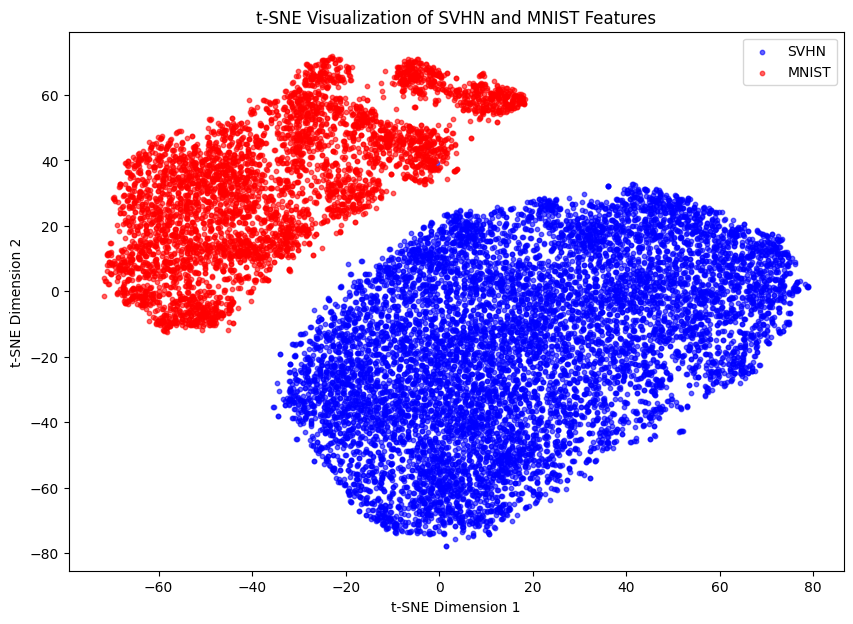

In [ ]:
visualize_features_with_tsne(transfer_model, svhn_train_subset_loader, mnist_test_subset_loader, source_label="SVHN", target_label="MNIST")

## DANN Architecture

#### Setting up the Reversal Layer function

In [ ]:
class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

#### DANN Model

In [ ]:
class DANN(nn.Module):
    def __init__(self, num_classes, alpha=1.0):
        super(DANN, self).__init__()
        self.alpha = alpha
        self.backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        # Task classifier head
        self.task_classifier = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

        # Domain classifier head
        self.dann_classifier = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Linear(256, 2) # Binary classification
        )

    def forward(self, x):
        features = self.backbone(x)
        features = features.view(features.size(0), -1)

        # Task classifier output
        class_outputs = self.task_classifier(features)

        # Domain classifier output
        if self.alpha is not None:
            reverse_features = ReverseLayerF.apply(features, self.alpha)
            domain_outputs = self.dann_classifier(reverse_features)
        else:
            domain_outputs = None

        return class_outputs, domain_outputs

#### Defining the training and evaluation functions for the DANN

In [ ]:
def train_dann(model, source_loader, target_loader, criterion_task, criterion_domain, optimizer, device, num_epochs):
    """
    Train the DANN model with dynamic domain loss weighting.
    """
    for epoch in range(num_epochs):
        model.train()
        running_task_loss = 0.0
        running_domain_loss = 0.0
        correct_task = 0
        correct_domain = 0
        total_task = 0
        total_domain = 0

        source_iter = iter(source_loader)
        target_iter = iter(target_loader)

        domain_loss_weight = 2 / (1 + np.exp(-10 * (epoch / num_epochs))) - 1

        for _ in tqdm(range(min(len(source_loader), len(target_loader))), desc=f"Epoch {epoch + 1}/{num_epochs}"):
            # Get source and target batches
            source_data = next(source_iter)
            target_data = next(target_iter)

            source_images, source_labels = source_data
            target_images, _ = target_data

            source_images, source_labels = source_images.to(device), source_labels.to(device)
            target_images = target_images.to(device)

            # Combine source and target
            images = torch.cat((source_images, target_images), dim=0)
            domains = torch.cat((
                torch.zeros(source_images.size(0)),  # 0 for source
                torch.ones(target_images.size(0))   # 1 for target
            )).long().to(device)

            # Forward pass
            task_output, domain_output = model(images)

            # Compute losses
            task_loss = criterion_task(task_output[:source_images.size(0)], source_labels)
            domain_loss = criterion_domain(domain_output, domains)

            loss = task_loss + domain_loss_weight * domain_loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Metrics
            running_task_loss += task_loss.item() * source_images.size(0)
            running_domain_loss += domain_loss.item() * images.size(0)
            _, task_preds = torch.max(task_output[:source_images.size(0)], 1)
            _, domain_preds = torch.max(domain_output, 1)
            correct_task += (task_preds == source_labels).sum().item()
            correct_domain += (domain_preds == domains).sum().item()
            total_task += source_images.size(0)
            total_domain += images.size(0)

        # Log metrics
        epoch_task_loss = running_task_loss / total_task
        epoch_domain_loss = running_domain_loss / total_domain
        task_accuracy = 100.0 * correct_task / total_task
        domain_accuracy = 100.0 * correct_domain / total_domain

        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Task Loss: {epoch_task_loss:.4f}, Task Accuracy: {task_accuracy:.2f}%")
        print(f"Domain Loss: {epoch_domain_loss:.4f}, Domain Accuracy: {domain_accuracy:.2f}%")
        print("-" * 50)


# Function for evaluating the DANN model
def evaluate_model_dann(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total
    return accuracy

### Office-31 Dataset Experiments

#### First Experiment A -> W

In [14]:
learning_rate = 0.001
model = DANN(num_classes=31, alpha=1.0).to(device)

# Define optimizer with variable learning rates
optimizer = optim.SGD([
    {'params': model.backbone.parameters(), 'lr': learning_rate * 0.1},  # Backbone has a smaller LR
    {'params': model.task_classifier.parameters(), 'lr': learning_rate},  # Task classifier
    {'params': model.dann_classifier.parameters(), 'lr': learning_rate},  # Domain classifier
], lr=learning_rate, weight_decay=5e-4)

criterion_task = nn.CrossEntropyLoss()  # Task classification loss
criterion_domain = nn.CrossEntropyLoss()  # Domain classification loss

amazon_dataloader = load_data(data_path, 'amazon', 64, 'src')
webcam_dataloader = load_data(data_path, 'webcam', 64, 'tar')

# Train the DANN model
train_dann(model, amazon_dataloader, webcam_dataloader, criterion_task, criterion_domain, optimizer, device, num_epochs=5)

# Evaluate the model on the target domain
val_accuracy = evaluate_model_dann(model, webcam_dataloader)
print(f"Target Domain Evaluation - Accuracy: {val_accuracy:.2f}%")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/5: 100%|██████████| 12/12 [02:54<00:00, 14.56s/it]

Epoch 1/5
Task Loss: 3.4307, Task Accuracy: 3.91%
Domain Loss: 0.6892, Domain Accuracy: 54.04%
--------------------------------------------------



Epoch 2/5: 100%|██████████| 12/12 [01:30<00:00,  7.56s/it]

Epoch 2/5
Task Loss: 3.4307, Task Accuracy: 3.26%
Domain Loss: 0.6886, Domain Accuracy: 53.97%
--------------------------------------------------



Epoch 3/5: 100%|██████████| 12/12 [00:58<00:00,  4.92s/it]

Epoch 3/5
Task Loss: 3.4325, Task Accuracy: 3.52%
Domain Loss: 0.6878, Domain Accuracy: 54.43%
--------------------------------------------------



Epoch 4/5: 100%|██████████| 12/12 [00:45<00:00,  3.78s/it]

Epoch 4/5
Task Loss: 3.4271, Task Accuracy: 3.39%
Domain Loss: 0.6848, Domain Accuracy: 56.64%
--------------------------------------------------



Epoch 5/5: 100%|██████████| 12/12 [00:18<00:00,  1.57s/it]


Epoch 5/5
Task Loss: 3.4291, Task Accuracy: 2.60%
Domain Loss: 0.6836, Domain Accuracy: 57.42%
--------------------------------------------------
Target Domain Evaluation - Accuracy: 2.86%


#### Second Experiment A -> D

In [ ]:
num_classes = len(amazon_dataset.classes)
model = DANN(num_classes, alpha=0.1).to(device)

criterion_task = nn.CrossEntropyLoss()  # Task classification loss
criterion_domain = nn.CrossEntropyLoss()  # Domain classification loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the DANN model
train_dann(model, amazon_dataloader, dslr_dataloader, criterion_task, criterion_domain, optimizer, device, num_epochs=10)

# Evaluate the model on the target domain
val_accuracy = evaluate_model_dann(model, dslr_dataloader)
print(f"Target Domain Evaluation - Accuracy: {val_accuracy:.2f}%")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Epoch 1/10: 100%|██████████| 8/8 [01:57<00:00, 14.67s/it]

Epoch 1/10
Task Loss: 3.6898, Task Accuracy: 3.12%
Domain Loss: 1.1210, Domain Accuracy: 48.73%
--------------------------------------------------



Epoch 2/10: 100%|██████████| 8/8 [00:20<00:00,  2.52s/it]

Epoch 2/10
Task Loss: 3.4329, Task Accuracy: 4.49%
Domain Loss: 1.6060, Domain Accuracy: 26.47%
--------------------------------------------------



Epoch 3/10: 100%|██████████| 8/8 [00:19<00:00,  2.45s/it]

Epoch 3/10
Task Loss: 3.4457, Task Accuracy: 4.88%
Domain Loss: 0.8095, Domain Accuracy: 63.92%
--------------------------------------------------



Epoch 4/10: 100%|██████████| 8/8 [00:19<00:00,  2.47s/it]

Epoch 4/10
Task Loss: 3.4535, Task Accuracy: 3.32%
Domain Loss: 5.8200, Domain Accuracy: 8.73%
--------------------------------------------------



Epoch 5/10: 100%|██████████| 8/8 [00:19<00:00,  2.47s/it]

Epoch 5/10
Task Loss: 3.4191, Task Accuracy: 5.47%
Domain Loss: 1.4777, Domain Accuracy: 54.51%
--------------------------------------------------



Epoch 6/10: 100%|██████████| 8/8 [00:18<00:00,  2.34s/it]

Epoch 6/10
Task Loss: 3.3976, Task Accuracy: 6.45%
Domain Loss: 4.6644, Domain Accuracy: 30.69%
--------------------------------------------------



Epoch 7/10: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it]

Epoch 7/10
Task Loss: 3.3343, Task Accuracy: 7.81%
Domain Loss: 1.7982, Domain Accuracy: 39.02%
--------------------------------------------------



Epoch 8/10: 100%|██████████| 8/8 [00:15<00:00,  1.93s/it]

Epoch 8/10
Task Loss: 3.2974, Task Accuracy: 8.79%
Domain Loss: 1.6866, Domain Accuracy: 51.96%
--------------------------------------------------



Epoch 9/10: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it]

Epoch 9/10
Task Loss: 3.2696, Task Accuracy: 6.25%
Domain Loss: 1.4971, Domain Accuracy: 43.73%
--------------------------------------------------



Epoch 10/10: 100%|██████████| 8/8 [00:21<00:00,  2.73s/it]

Epoch 10/10
Task Loss: 3.2163, Task Accuracy: 10.35%
Domain Loss: 0.4366, Domain Accuracy: 88.33%
--------------------------------------------------


Target Domain Evaluation - Accuracy: 1.97%


Third Experiment W -> A

In [ ]:
num_classes = len(amazon_dataset.classes)
model = DANN(num_classes, alpha=0.1).to(device)

criterion_task = nn.CrossEntropyLoss()  # Task classification loss
criterion_domain = nn.CrossEntropyLoss()  # Domain classification loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the DANN model
train_dann(model, webcam_dataloader, amazon_dataloader, criterion_task, criterion_domain, optimizer, device, num_epochs=10)

# Evaluate the model on the target domain
val_accuracy = evaluate_model_dann(model, amazon_dataloader)
print(f"Target Domain Evaluation - Accuracy: {val_accuracy:.2f}%")

Epoch 1/10: 100%|██████████| 13/13 [00:18<00:00,  1.45s/it]

Epoch 1/10
Task Loss: 3.4217, Task Accuracy: 8.93%
Domain Loss: 0.9207, Domain Accuracy: 53.60%
--------------------------------------------------



Epoch 2/10: 100%|██████████| 13/13 [00:19<00:00,  1.47s/it]

Epoch 2/10
Task Loss: 2.9473, Task Accuracy: 14.34%
Domain Loss: 0.6622, Domain Accuracy: 64.78%
--------------------------------------------------



Epoch 3/10: 100%|██████████| 13/13 [00:18<00:00,  1.42s/it]

Epoch 3/10
Task Loss: 2.6395, Task Accuracy: 20.13%
Domain Loss: 0.6783, Domain Accuracy: 65.64%
--------------------------------------------------



Epoch 4/10: 100%|██████████| 13/13 [00:18<00:00,  1.41s/it]

Epoch 4/10
Task Loss: 2.3435, Task Accuracy: 27.17%
Domain Loss: 0.5476, Domain Accuracy: 72.03%
--------------------------------------------------



Epoch 5/10: 100%|██████████| 13/13 [00:18<00:00,  1.43s/it]

Epoch 5/10
Task Loss: 2.2945, Task Accuracy: 27.30%
Domain Loss: 0.5745, Domain Accuracy: 72.16%
--------------------------------------------------



Epoch 6/10: 100%|██████████| 13/13 [00:18<00:00,  1.43s/it]

Epoch 6/10
Task Loss: 2.1703, Task Accuracy: 30.94%
Domain Loss: 0.4821, Domain Accuracy: 76.71%
--------------------------------------------------



Epoch 7/10: 100%|██████████| 13/13 [00:18<00:00,  1.41s/it]

Epoch 7/10
Task Loss: 2.1271, Task Accuracy: 32.33%
Domain Loss: 0.4485, Domain Accuracy: 78.98%
--------------------------------------------------



Epoch 8/10: 100%|██████████| 13/13 [00:18<00:00,  1.43s/it]

Epoch 8/10
Task Loss: 1.9364, Task Accuracy: 40.50%
Domain Loss: 0.4574, Domain Accuracy: 80.21%
--------------------------------------------------



Epoch 9/10: 100%|██████████| 13/13 [00:18<00:00,  1.43s/it]

Epoch 9/10
Task Loss: 1.6945, Task Accuracy: 43.27%
Domain Loss: 0.4825, Domain Accuracy: 78.80%
--------------------------------------------------



Epoch 10/10: 100%|██████████| 13/13 [00:18<00:00,  1.41s/it]


Epoch 10/10
Task Loss: 1.5961, Task Accuracy: 47.42%
Domain Loss: 0.4755, Domain Accuracy: 79.84%
--------------------------------------------------
Target Domain Evaluation - Accuracy: 4.93%


#### Fourth Experiment W -> D

In [ ]:
num_classes = len(amazon_dataset.classes)
model = DANN(num_classes, alpha=0.1).to(device)

criterion_task = nn.CrossEntropyLoss()  # Task classification loss
criterion_domain = nn.CrossEntropyLoss()  # Domain classification loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the DANN model
train_dann(model, webcam_dataloader, dslr_dataloader, criterion_task, criterion_domain, optimizer, device, num_epochs=10)

# Evaluate the model on the target domain
val_accuracy = evaluate_model_dann(model, dslr_dataloader)
print(f"Target Domain Evaluation - Accuracy: {val_accuracy:.2f}%")

#### Fifth Experiment D -> A

In [ ]:
num_classes = len(amazon_dataset.classes)
model = DANN(num_classes, alpha=0.1).to(device)

criterion_task = nn.CrossEntropyLoss()  # Task classification loss
criterion_domain = nn.CrossEntropyLoss()  # Domain classification loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the DANN model
train_dann(model, dslr_dataloader, amazon_dataloader, criterion_task, criterion_domain, optimizer, device, num_epochs=10)

# Evaluate the model on the target domain
val_accuracy = evaluate_model_dann(model, amazon_dataloader)
print(f"Target Domain Evaluation - Accuracy: {val_accuracy:.2f}%")

#### Sixth Experiment D -> W

In [ ]:
num_classes = len(amazon_dataset.classes)
model = DANN(num_classes, alpha=0.1).to(device)

criterion_task = nn.CrossEntropyLoss()  # Task classification loss
criterion_domain = nn.CrossEntropyLoss()  # Domain classification loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the DANN model
train_dann(model, dslr_dataloader, webcam_dataloader, criterion_task, criterion_domain, optimizer, device, num_epochs=10)

# Evaluate the model on the target domain
val_accuracy = evaluate_model_dann(model, webcam_dataloader)
print(f"Target Domain Evaluation - Accuracy: {val_accuracy:.2f}%")

### Digits Dataset Experiments

#### DANN First Experiment M -> U

In [17]:
# num_classes = 10
# model = DANN(num_classes, alpha=0.1).to(device)

# criterion_task = nn.CrossEntropyLoss()  # Task classification loss
# criterion_domain = nn.CrossEntropyLoss()  # Domain classification loss
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# # Train the DANN model
# train_dann(model, mnist_train_subset_loader, usps_train_subset_loader, criterion_task, criterion_domain, optimizer, device, num_epochs=10)

# # Evaluate the model on the target domain
# val_accuracy = evaluate_model_dann(model, usps_test_subset_loader)
# print(f"Target Domain Evaluation - Accuracy: {val_accuracy:.2f}%")

learning_rate = 0.001
model = DANN(num_classes=10, alpha=1.0).to(device)

# Define optimizer with variable learning rates
optimizer = optim.SGD([
    {'params': model.backbone.parameters(), 'lr': learning_rate * 0.1},  # Backbone has a smaller LR
    {'params': model.task_classifier.parameters(), 'lr': learning_rate},  # Task classifier
    {'params': model.dann_classifier.parameters(), 'lr': learning_rate},  # Domain classifier
], lr=learning_rate, weight_decay=5e-4)

criterion_task = nn.CrossEntropyLoss()  # Task classification loss
criterion_domain = nn.CrossEntropyLoss()  # Domain classification loss

# Train the DANN model
train_dann(model, mnist_train_subset_loader, usps_train_subset_loader, criterion_task, criterion_domain, optimizer, device, num_epochs=5)

# Evaluate the model on the target domain
val_accuracy = evaluate_model_dann(model, usps_test_subset_loader)
print(f"Target Domain Evaluation - Accuracy: {val_accuracy:.2f}%")

Epoch 1/5: 100%|██████████| 79/79 [01:45<00:00,  1.34s/it]


Epoch 1/5
Task Loss: 2.2943, Task Accuracy: 15.03%
Domain Loss: 0.6873, Domain Accuracy: 61.56%
--------------------------------------------------


Epoch 2/5: 100%|██████████| 79/79 [01:47<00:00,  1.36s/it]


Epoch 2/5
Task Loss: 2.2887, Task Accuracy: 16.57%
Domain Loss: 0.6778, Domain Accuracy: 72.19%
--------------------------------------------------


Epoch 3/5: 100%|██████████| 79/79 [01:47<00:00,  1.35s/it]


Epoch 3/5
Task Loss: 2.2824, Task Accuracy: 19.94%
Domain Loss: 0.6510, Domain Accuracy: 91.35%
--------------------------------------------------


Epoch 4/5: 100%|██████████| 79/79 [01:47<00:00,  1.36s/it]


Epoch 4/5
Task Loss: 2.2772, Task Accuracy: 22.35%
Domain Loss: 0.6215, Domain Accuracy: 96.95%
--------------------------------------------------


Epoch 5/5: 100%|██████████| 79/79 [01:47<00:00,  1.36s/it]


Epoch 5/5
Task Loss: 2.2733, Task Accuracy: 24.03%
Domain Loss: 0.5919, Domain Accuracy: 99.04%
--------------------------------------------------
Target Domain Evaluation - Accuracy: 9.80%


#### DANN Second Experiment U -> M

In [ ]:
num_classes = 10
model = DANN(num_classes, alpha=0.1).to(device)

criterion_task = nn.CrossEntropyLoss()  # Task classification loss
criterion_domain = nn.CrossEntropyLoss() # Domain classification loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the DANN model
train_dann(model, usps_train_subset_loader, mnist_train_subset_loader, criterion_task, criterion_domain, optimizer, device, num_epochs=10)

# Evaluate the model on the target domain
val_accuracy = evaluate_model_dann(model, mnist_test_subset_loader)
print(f"Target Domain Evaluation - Accuracy: {val_accuracy:.2f}%")

Epoch 1/10: 100%|██████████| 16/16 [00:24<00:00,  1.53s/it]


Epoch 1/10
Task Loss: 2.1972, Task Accuracy: 24.80%
Domain Loss: 0.7683, Domain Accuracy: 61.30%
--------------------------------------------------


Epoch 2/10: 100%|██████████| 16/16 [00:25<00:00,  1.58s/it]


Epoch 2/10
Task Loss: 1.6393, Task Accuracy: 38.50%
Domain Loss: 2.3844, Domain Accuracy: 38.75%
--------------------------------------------------


Epoch 3/10: 100%|██████████| 16/16 [00:24<00:00,  1.56s/it]


Epoch 3/10
Task Loss: 1.0180, Task Accuracy: 59.00%
Domain Loss: 1.0244, Domain Accuracy: 46.55%
--------------------------------------------------


Epoch 4/10: 100%|██████████| 16/16 [00:25<00:00,  1.57s/it]


Epoch 4/10
Task Loss: 0.7662, Task Accuracy: 71.50%
Domain Loss: 0.9076, Domain Accuracy: 52.30%
--------------------------------------------------


Epoch 5/10: 100%|██████████| 16/16 [00:24<00:00,  1.50s/it]


Epoch 5/10
Task Loss: 0.5947, Task Accuracy: 80.00%
Domain Loss: 0.7049, Domain Accuracy: 58.85%
--------------------------------------------------


Epoch 6/10: 100%|██████████| 16/16 [00:24<00:00,  1.55s/it]


Epoch 6/10
Task Loss: 0.3490, Task Accuracy: 87.30%
Domain Loss: 0.5792, Domain Accuracy: 67.85%
--------------------------------------------------


Epoch 7/10: 100%|██████████| 16/16 [00:25<00:00,  1.57s/it]


Epoch 7/10
Task Loss: 0.2335, Task Accuracy: 92.50%
Domain Loss: 0.5650, Domain Accuracy: 74.00%
--------------------------------------------------


Epoch 8/10: 100%|██████████| 16/16 [00:25<00:00,  1.57s/it]


Epoch 8/10
Task Loss: 0.1618, Task Accuracy: 95.10%
Domain Loss: 0.5871, Domain Accuracy: 70.10%
--------------------------------------------------


Epoch 9/10: 100%|██████████| 16/16 [00:24<00:00,  1.55s/it]


Epoch 9/10
Task Loss: 0.1493, Task Accuracy: 95.30%
Domain Loss: 0.6680, Domain Accuracy: 63.95%
--------------------------------------------------


Epoch 10/10: 100%|██████████| 16/16 [00:25<00:00,  1.57s/it]


Epoch 10/10
Task Loss: 0.1297, Task Accuracy: 96.30%
Domain Loss: 0.7650, Domain Accuracy: 47.60%
--------------------------------------------------
Target Domain Evaluation - Accuracy: 53.20%


#### DANN Third Experiment S -> M

In [ ]:
num_classes = 10
model = DANN(num_classes, alpha=0.1).to(device)

criterion_task = nn.CrossEntropyLoss()  # Task classification loss
criterion_domain = nn.CrossEntropyLoss() # Domain classification loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the DANN model
train_dann(model, svhn_train_subset_loader, mnist_train_subset_loader, criterion_task, criterion_domain, optimizer, device, num_epochs=10)

# Evaluate the model on the target domain
val_accuracy = evaluate_model_dann(model, mnist_test_subset_loader)
print(f"Target Domain Evaluation - Accuracy: {val_accuracy:.2f}%")

Epoch 1/10: 100%|██████████| 16/16 [00:25<00:00,  1.56s/it]


Epoch 1/10
Task Loss: 2.3910, Task Accuracy: 18.10%
Domain Loss: 0.9069, Domain Accuracy: 60.05%
--------------------------------------------------


Epoch 2/10: 100%|██████████| 16/16 [00:25<00:00,  1.58s/it]


Epoch 2/10
Task Loss: 2.3173, Task Accuracy: 13.50%
Domain Loss: 2.7557, Domain Accuracy: 18.05%
--------------------------------------------------


Epoch 3/10: 100%|██████████| 16/16 [00:24<00:00,  1.56s/it]


Epoch 3/10
Task Loss: 2.2968, Task Accuracy: 17.60%
Domain Loss: 1.7538, Domain Accuracy: 24.75%
--------------------------------------------------


Epoch 4/10: 100%|██████████| 16/16 [00:25<00:00,  1.56s/it]


Epoch 4/10
Task Loss: 2.2624, Task Accuracy: 18.20%
Domain Loss: 1.4889, Domain Accuracy: 41.00%
--------------------------------------------------


Epoch 5/10: 100%|██████████| 16/16 [00:25<00:00,  1.57s/it]


Epoch 5/10
Task Loss: 2.2592, Task Accuracy: 17.70%
Domain Loss: 0.7981, Domain Accuracy: 62.65%
--------------------------------------------------


Epoch 6/10: 100%|██████████| 16/16 [00:25<00:00,  1.57s/it]


Epoch 6/10
Task Loss: 2.2668, Task Accuracy: 18.10%
Domain Loss: 1.3870, Domain Accuracy: 27.55%
--------------------------------------------------


Epoch 7/10: 100%|██████████| 16/16 [00:24<00:00,  1.55s/it]


Epoch 7/10
Task Loss: 2.2568, Task Accuracy: 19.20%
Domain Loss: 0.2183, Domain Accuracy: 99.40%
--------------------------------------------------


Epoch 8/10: 100%|██████████| 16/16 [00:25<00:00,  1.57s/it]


Epoch 8/10
Task Loss: 2.2321, Task Accuracy: 19.90%
Domain Loss: 0.0988, Domain Accuracy: 98.30%
--------------------------------------------------


Epoch 9/10: 100%|██████████| 16/16 [00:25<00:00,  1.57s/it]


Epoch 9/10
Task Loss: 2.2509, Task Accuracy: 19.90%
Domain Loss: 2.0034, Domain Accuracy: 8.50%
--------------------------------------------------


Epoch 10/10: 100%|██████████| 16/16 [00:24<00:00,  1.56s/it]


Epoch 10/10
Task Loss: 2.2504, Task Accuracy: 18.80%
Domain Loss: 0.3921, Domain Accuracy: 88.40%
--------------------------------------------------
Target Domain Evaluation - Accuracy: 11.20%
